In [ ]:
!python --version

Python 3.10.12


In [ ]:
pip install scikit-learn

In [ ]:
pip install scipy

In [2]:
pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.8 MB/s eta 0:00:00


In [ ]:
! pip install tensorflow

# 4G ANOMALY DETECTION
Günümüzde 4G baz istasyonu verilerinin analizi, trafik yoğunluğunun fazla olduğu zamanlarda oluşan anomalilerin tespit edilmesi ve bu analiz ile sistemin daha iyi hale geitirlmesi, taleplerin daha hızlı bir şekilde yanıtlanması ve bu sayede de trafiğin daha iyi yönetilmesi gibi birçok avantaj sağlamaktadır. Bu konunun karmaşıklığı, verilerin fazla ve değişken aralıklarda olması gibi dezavantajların doğurduğu sebepler doğrultusunda böyle bir sorunun makine öğrenmesi yardımıyla yapılması günümüzde başvurulabilecek en mantıksal ve yapıcı çözüm olacaktır.Bu bağlamda [Kaggle üzerinde bulunan 4G Anomaly veriseti](https://www.kaggle.com/c/anomaly-detection-in-4g-cellular-networks/data) baz alınarak makine öğrensmesi gerçekleştirilecektir. Makine öğrenemesinde kullanılacak verisetini inceleyecek olursak:

### Veriseti
  Kaggle'da bulunan veriseti, on farklı baz istasyonunda belirli aralıklarla alınarak toplanan ve birçok parametreyi içeren 37 bine yakın veriye sahip bir settir.
  Buradaki parametreler sırası ile şu şekildedir:

  1. **Time**:  Verilerin baz istasyonundan alındığı zamanı içeren sütundur.
  2. **CellName**: Bazistasyonunun ismini tutan sütundur.
  3. **PRBUsageUL**: Spesifik baz istasyonundaki kaynak kullanım düzeyidir. Fiziksel Radyo Bloklarının (PRB) yüzdesi olarak ölçülen bir değerdir. Uplink için ölçümü temsil eder. (Uplink, kullanıcının cihazından iletişim ağına doğru veri gönderildiği yöndür.)
  4. **PRBUsageDL**: Spesifik baz istasyonundaki kaynak kullanım düzeyidir. Fiziksel Radyo Bloklarının (PRB) yüzdesi olarak ölçülen bir değerdir. Downlink için ölçümü temsil eder.(Downlink, iletişim ağından kullanıcının cihazına doğru veri gönderildiği yöndür.)
  5. **meanThr_DL**:  Ortalama taşınan trafiktir, downlink için değerleri tutar.
  6. **meanThr_UL**: Ortalama taşınan trafiktir, uplink için değerleri tutar.
  7. **maxThr_DL**: Maksimum taşınan trafiktir, downlink için değerleri tutar.
  8. **maxThr_UL**: Maksimum taşınan trafiktir, uplink için değerleri tutar.
  9. **meanUE_DL**:  Eş zamanlı olarak aktif olan kullanıcı ekipmanı (UE) cihazlarının ortalama sayısı ölçülür. Downlink için değerleri tutar.
  10. **meanUE_UL**: Eş zamanlı olarak aktif olan kullanıcı ekipmanı cihazlarının ortalama sayısı ölçülür. Uplink için değerleri tutar.
  11. **maxUE_DL**: Eş zamanlı olarak aktif olan kullanıcı ekipmanı  cihazlarının maksimum sayısı ölçülür. Downlink için değerleri tutar.
  12.**maxUE_UL**: Eş zamanlı olarak aktif olan kullanıcı ekipmanı cihazlarının maksimum sayısı ölçülür. Uplink için değerleri tutar.
  13. **maxUE_UL+DL**: Uplink ve downlink ayrımı yapılmaksızın eş zamanlı olarak aktif olan kullanıcı ekipmanı  cihazlarının maksimum sayısı ölçülür.
  14. **Unusual**: Verisetindeki bilgilere göre baz istasyonunda anomali olup olmadığını göstren etikettir.

  Verisetindeki eğitim için gerekli veri miktarının bu eğitim için gerekli olmasından dolayı preprocessing işleminde sonra data augmentation (veri artırma) aşaması uygulanmayacaktır ve feature extraction ile en üst seviyede çıkarım yapılacak ve en önemli bulunan feature ile feature selection aşamasına geçilmiş olacaktır. Daha sonra ise modelin veriseti supervised olarak (label olduğu için) ouşturulduğu için sınırlandırıcıya yüklenip test veri seti ile modelin doğruluğu test edilecektir. Burada bahsedilen aşamalar her adımda daha fazla açıklanacaktır.

[Genel takip edilen bir başka kaynak.](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

## 1. Preprocessing
Verisetinde bulunan eğitim için gerekli her verinin aynı şekilde işlenebilir hale getirilmesi geekmektedir, öğreneğin bu verisetinde bulunan CellName ve Time string cinsinden verilerdir ve özellikle zamanla bazistasyonunun trafiğinin belirli bir ilişkisi olacağının hepimiz farkındayızdır. Yani insanların belirli zaman aralıklarındaki uplinkve downlink oranının artışı ve azalışı gibi durumlar zamanla paralel bir ilişki içinde diyebiliriz. Bu durumun gerektirdiği önişlem sayesinde tüm verilerin eğitim için kullanılabilir hale getirilmesi sağlanacaktır.

In [ ]:
import pandas as pd
import numpy as np
import math

def preprocess_data(df):
    def convert_time_to_radians(time_str):
        hours, minutes = map(int, time_str.split(':'))
        total_minutes = hours * 60 + minutes
        radians = 2 * np.pi * total_minutes / (24 * 60)
        return radians

    def map_cell_name(cell_name):
        cell_name_mapping = {name: i + 1 for i, name in enumerate(df['CellName'].unique())}
        return cell_name_mapping.get(cell_name, 0)

    df['Time'] = df['Time'].apply(convert_time_to_radians)
    df['TimeCos'] = df['Time'].apply(lambda x: np.cos(x))
    df['TimeSin'] = df['Time'].apply(lambda x: np.sin(x))
    del df['Time']

    df['CellName'] = df['CellName'].apply(map_cell_name)

    return df

df = pd.read_csv('/home/tugbakara/YL/dersler/pattern-recognition/dataset/ML-MATT-CompetitionQT2021_train.csv', delimiter=';')

processed_df = preprocess_data(df.copy())

processed_df.to_csv('/home/tugbakara/YL/dersler/pattern-recognition/preprocess4G.csv', index=False)


## 2. Feature Extraction / Feature Selection
Öznitelik çıkartma ve seçme aşaması ile modelin hangi öznitelikte daha karakteristik bir şekle girdiğinin analizi için gerekli olmasından dolayı, verisetinde bulunan özelliklerin analizi, bunlar arasında oluşacak önemlilik derecesi de modelin doğruluğunda anahtar bir role sahip olmasından dolayı ve veri setinden zaman da olmasından dolayı hem dimension reduction yöntemi hem de zaman serisi verisetlerinde uygulanan algoritmalar denenmiştir.

  Algoritmalara geçmeden önce gerekli kütüphaneleri import edelim ve *önişlemden* geçirip kaydettiğimiz veri setlerini ekleyelim.

In [3]:
import pandas as pd
import dtreeviz
import matplotlib.pyplot as plt
import numpy
import time
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from sklearn.svm import LinearSVC
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor,HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA, FastICA, KernelPCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsClassifier,  NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold,cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, RFECV, SequentialFeatureSelector, SelectKBest, f_classif, SelectPercentile
from sklearn.svm import SVC
from sklearn.linear_model import LassoCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, classification_report, make_scorer

from scipy.stats import kendalltau
from scipy.cluster import hierarchy
from scipy.spatial import distance

from collections import defaultdict

from statsmodels.tsa.ar_model import AutoReg

from time import time

from itertools import combinations

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv1D, GlobalMaxPooling1D, LSTM, Flatten, Bidirectional, TimeDistributed, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers



/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


In [4]:
traindata = pd.read_csv('/content/sample_data/preprocess4G.csv')
testdata = pd.read_csv('/content/sample_data/preprocess4G_test.csv')
datatrain = pd.read_csv('/content/sample_data/ML-MATT-CompetitionQT2021_train.csv', delimiter=';')
X = traindata.drop('Unusual', axis='columns')
y = traindata['Unusual']

X_train, X_validation, y_train, y_validation = train_test_split(X,y,train_size=0.8, random_state=42, stratify = y)
X_test = testdata

X_train_ = X_train.to_numpy()
y_train_ = y_train.to_numpy()
X_validation_ =X_validation.to_numpy()
y_validation_ = y_validation.to_numpy()
X_test = testdata.to_numpy()

### Feature Extraction

**1. PCA**

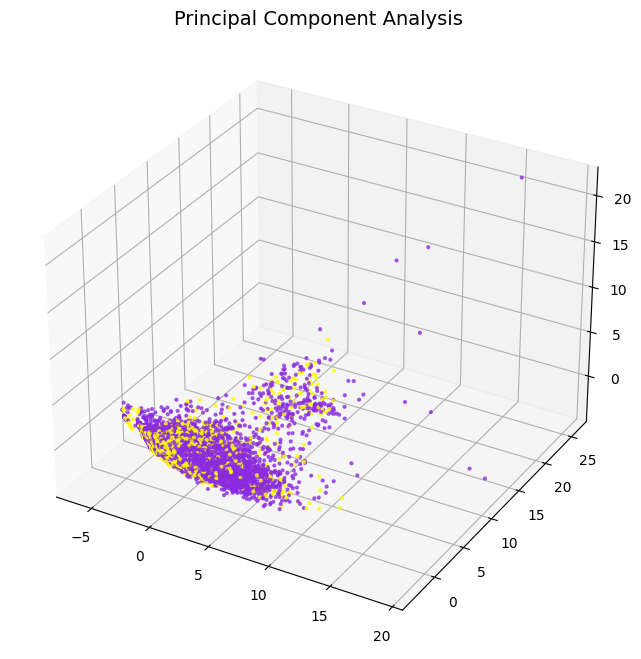

In [ ]:
pca = PCA(n_components=3)
scaler = StandardScaler()

X_norm = scaler.fit_transform(X_train)
X_reduce = pca.fit_transform(X_norm)

colors=['blueviolet' if l==0 else 'yellow' for l in y_train]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduce[:,0], X_reduce[:, 1], X_reduce[:, 2], s=4, alpha=0.7,color=colors)
plt.title('Principal Component Analysis', fontdict={'fontsize': 14, 'fontweight': 'normal'})
plt.show()

**2.Linear Discriminant Analysis**

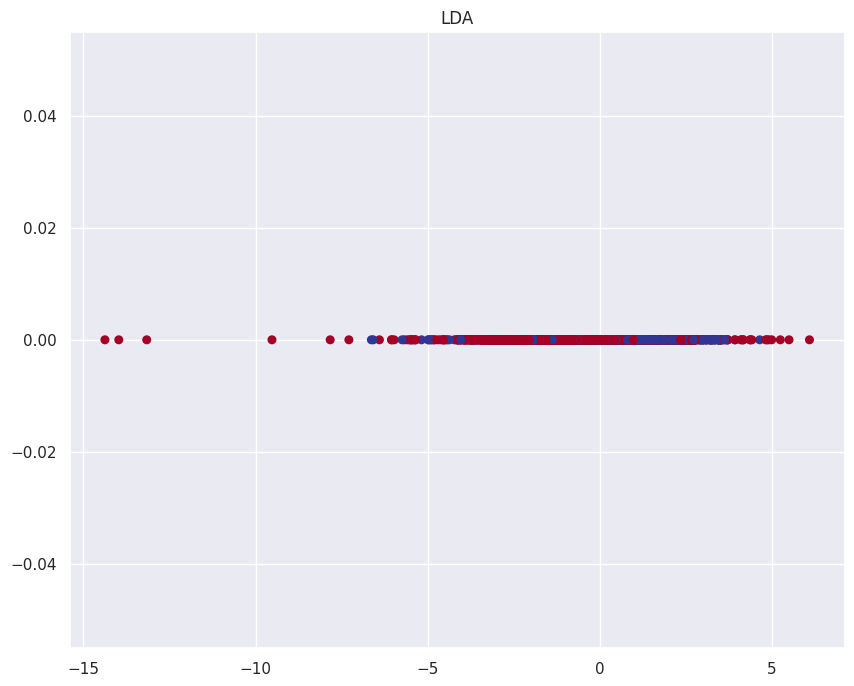

In [ ]:
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=1))
plt.figure(figsize=(10, 8))
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
plt.scatter(X_train_lda[:, 0], numpy.zeros_like(X_train_lda[:, 0]), c=y_train, s=30, cmap="RdYlBu")
plt.title("LDA")
plt.show()

**3. Neighborhood Component Analysis**

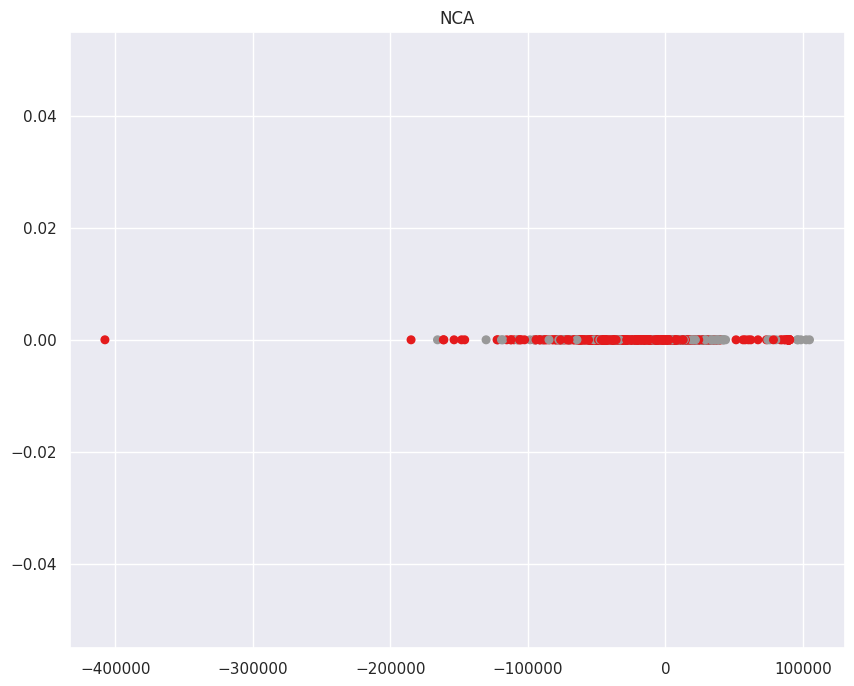

In [ ]:
nca = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(n_components=1, random_state=42))
plt.figure(figsize=(10, 8))
nca.fit(X_validation, y_validation)
X_train_nca = nca.transform(X_validation)
plt.scatter(X_train_nca[:, 0], numpy.zeros_like(X_train_nca[:, 0]), c=y_validation, s=30, cmap="Set1")
plt.title("NCA")
plt.show()

**4. Independent Component Analysis**

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.


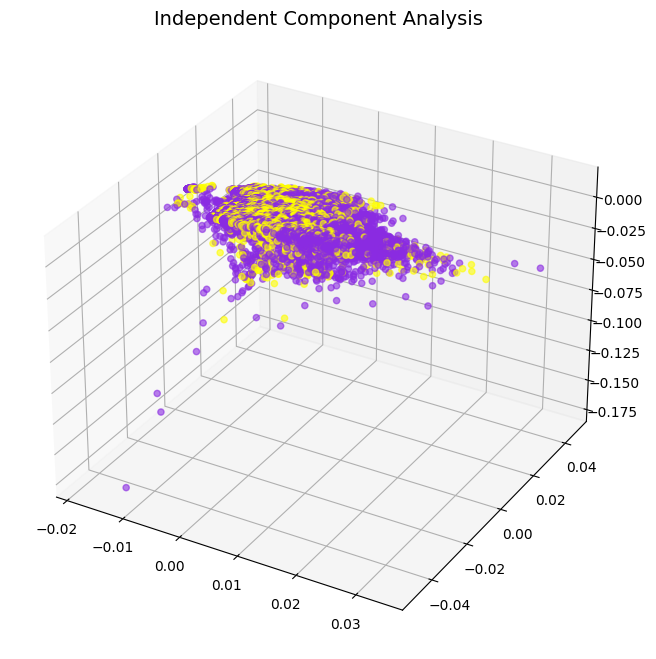

In [ ]:
ica = FastICA(n_components=3)
ica_result = ica.fit_transform(X_reduce)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ica_result[:, 0], ica_result[:, 1], ica_result[:, 2], alpha=0.6,color=colors)
plt.title('Independent Component Analysis', fontdict={'fontsize': 14, 'fontweight': 'normal'})
plt.show()

**5. Auto Regressive Model**

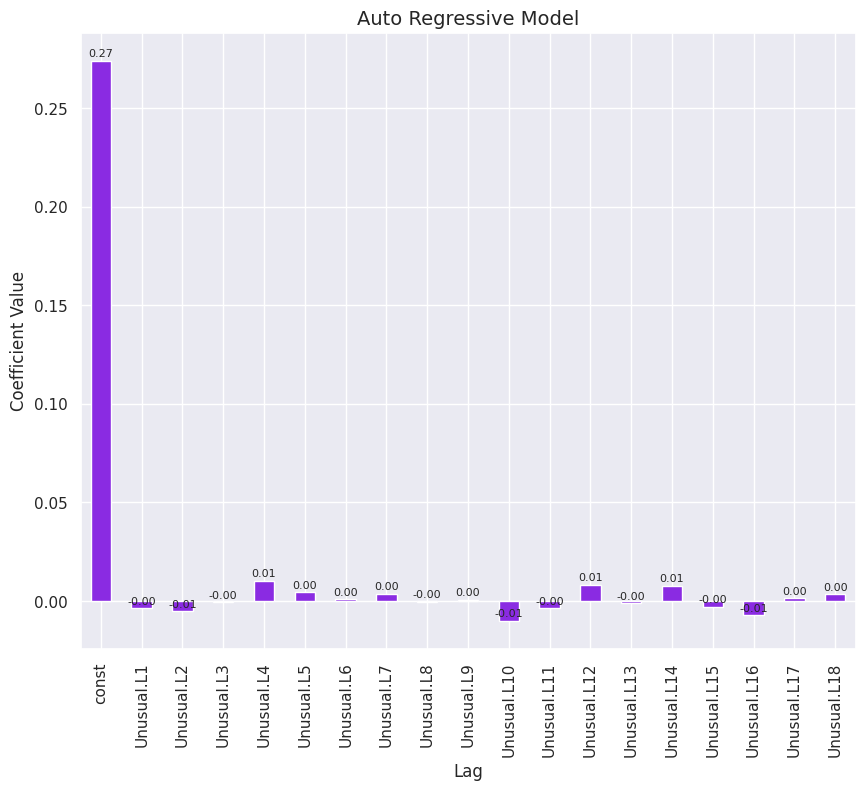

In [ ]:
ar_model = AutoReg(y, lags=18)
ar_result = ar_model.fit()
plt.figure(figsize=(10, 8))
ax = ar_result.params.plot(kind='bar', color='blueviolet')
for i, v in enumerate(ar_result.params):
    ax.text(i, v + 0.001, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

plt.title('Auto Regressive Model', fontdict={'fontsize': 14, 'fontweight': 'normal'})
plt.xlabel('Lag')
plt.ylabel('Coefficient Value')
plt.show()

**6. Kernel PCA**

[kaynak kod](https://www.datatechnotes.com/2022/01/kernelpca-projection-example-in-python.html)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kpca = KernelPCA(n_components=3, kernel='rbf', random_state=42)
X_kpca = kpca.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_kpca[:, 0], X_kpca[:, 1], X_kpca[:, 2] , c=y, cmap='viridis', alpha = 0.6)
plt.title('Kernel PCA')
ax.set_xlabel('kPCA 1')
ax.set_ylabel('kPCA 2')
ax.set_zlabel('kPCA 3')
plt.show()

**KernelPCA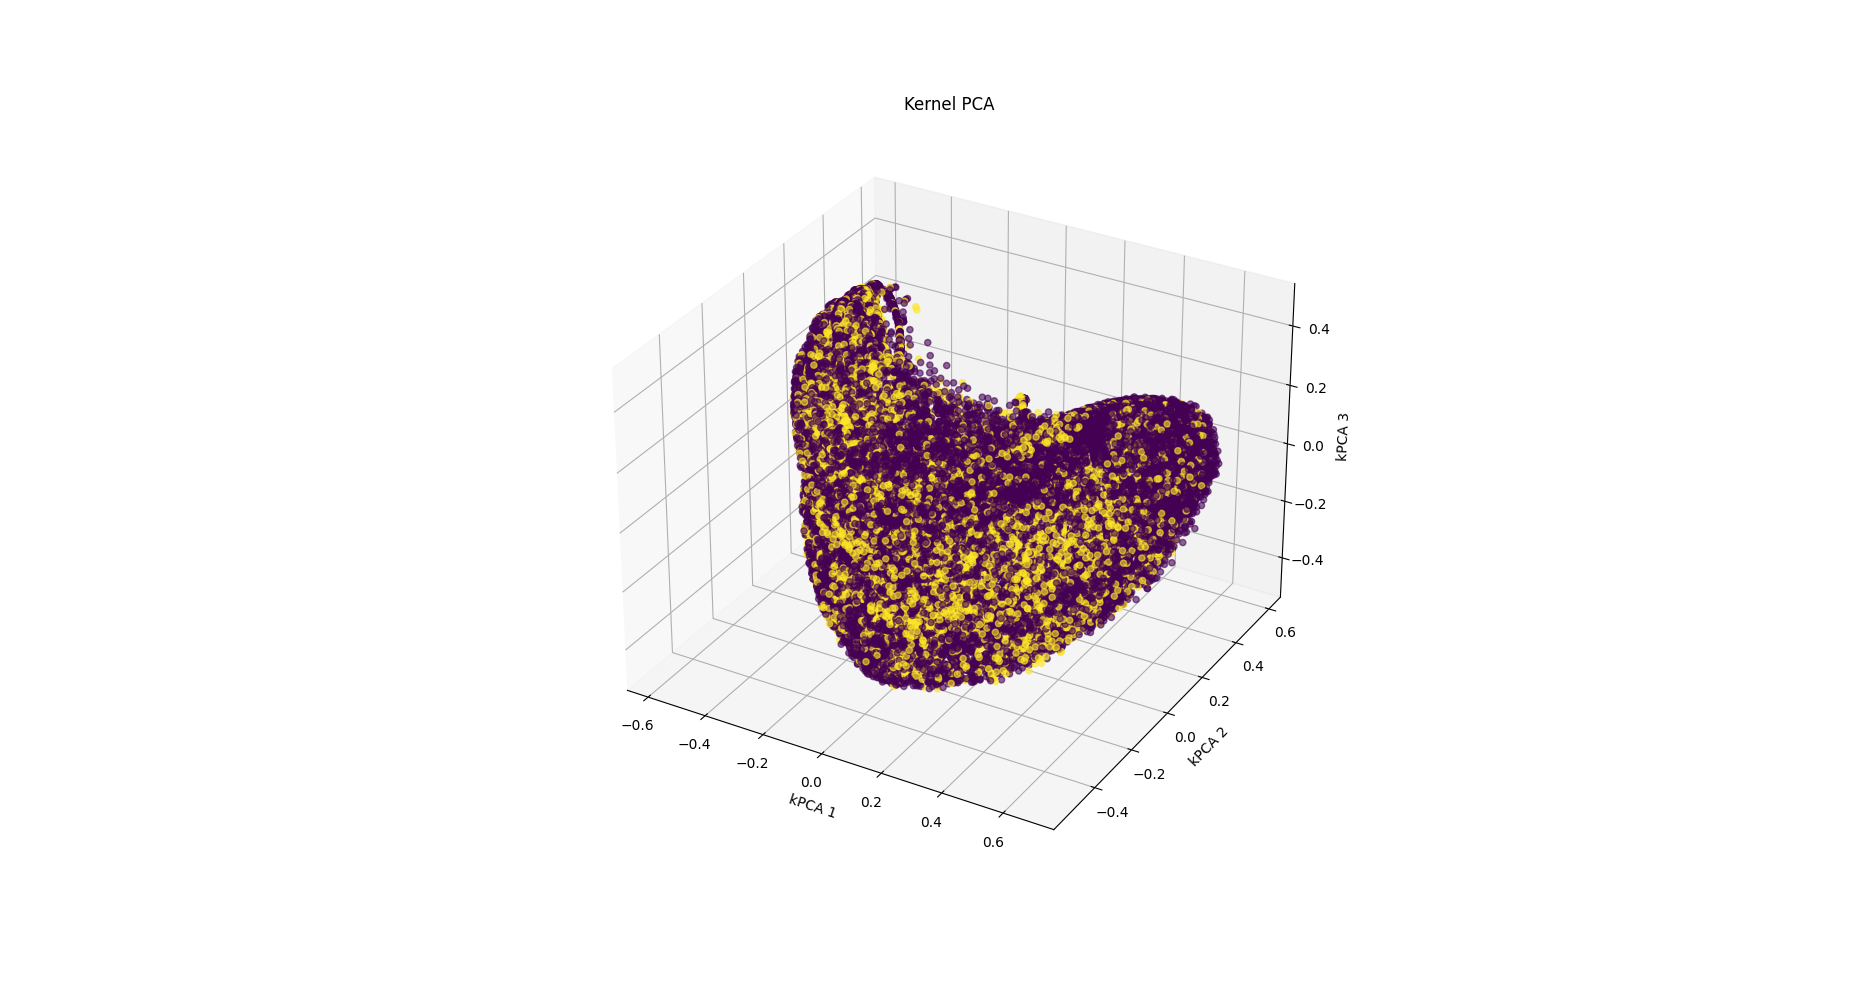**

**7. Singular Value Decomposition**

  Component'lar orijinal özellikleri bir araya getirerek veriyi daha düşük boyutlu bir uzayda temsil etmeye çalışır. Bu nedenle, bu bileşenlerin neyi temsil ettiği doğrudan orijinal özelliklere karşılık gelmez ve genellikle lineer kombinasyonlardır. Bu sebeple birleşimi yapılan componentların grafiğine bakmamız gerekir.

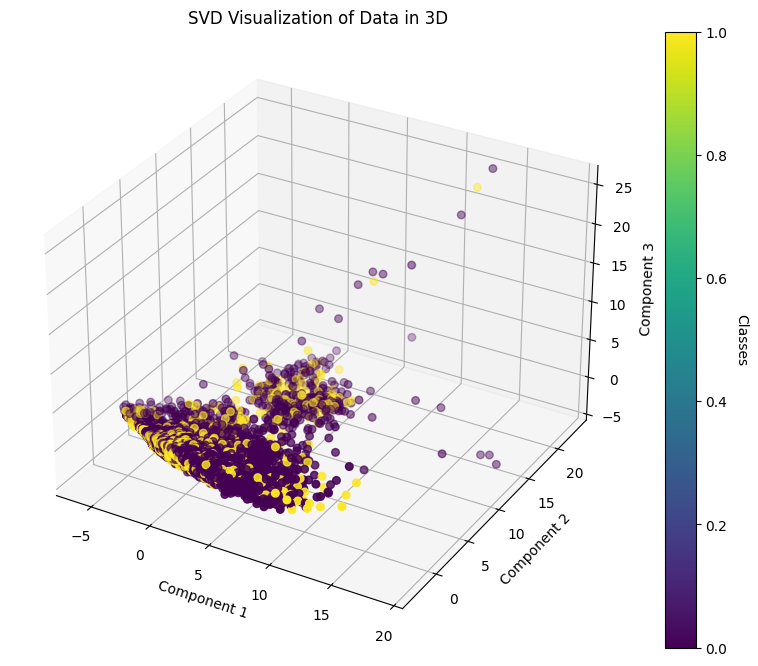

In [ ]:
X_combined = numpy.vstack((X_train, X_validation))
scaler = StandardScaler()
X_combined_std = scaler.fit_transform(X_combined)
svd = TruncatedSVD(n_components=3, random_state=42, algorithm='arpack', tol=0.001)
X_svd_3d = svd.fit_transform(X_combined_std)
svd_df_3d = pd.DataFrame(data=X_svd_3d, columns=['Component 1', 'Component 2', 'Component 3'])
svd_df_3d['Label'] = numpy.concatenate((y_train, y_validation))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(svd_df_3d['Component 1'], svd_df_3d['Component 2'], svd_df_3d['Component 3'],
                     c=svd_df_3d['Label'], cmap='viridis', marker='o', s=30)
cbar = fig.colorbar(scatter)
cbar.set_label('Classes', rotation=270, labelpad=15)
ax.set_title('SVD Visualization of Data in 3D')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

### Feature Selection

**1. Random Forest**

 Random Forest'da standartlaşırmaya gerek olmadığından dolayı random forest algortimasında veri ham olarak işlenmiştir.([kaynak1](https://builtin.com/data-science/when-and-why-standardize-your-data#:~:text=Cases%20When%20Standardization%20Is%20Not%20Needed))
  Ayrıca Confusion matrix, bir sınıflandırma modelinin performansını değerlendirmek için kullanılan bir tablodur. Bu matris, gerçek sınıfları ve modelin tahmin ettiği sınıfları gösterir.

                   True label
                    0        1
    Predicted   0  [TN]    [FP]
                1  [FN]    [TP]

  Embedded method olan andom Forest da model eğitiminin parçası olarak öznitelik seçimini bir iterativ işlem olarak gerçekleştirir. ([kaynak2](https://www.sciencedirect.com/science/article/pii/S0920410521008998#:~:text=2.1.3.%20Embedded%20method))
  Feature importance sklearn kütüphanesinin dökümanınına bakılarak gerçekleştirilmiştir. ([kaynak3](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) && [kaynak4](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html))

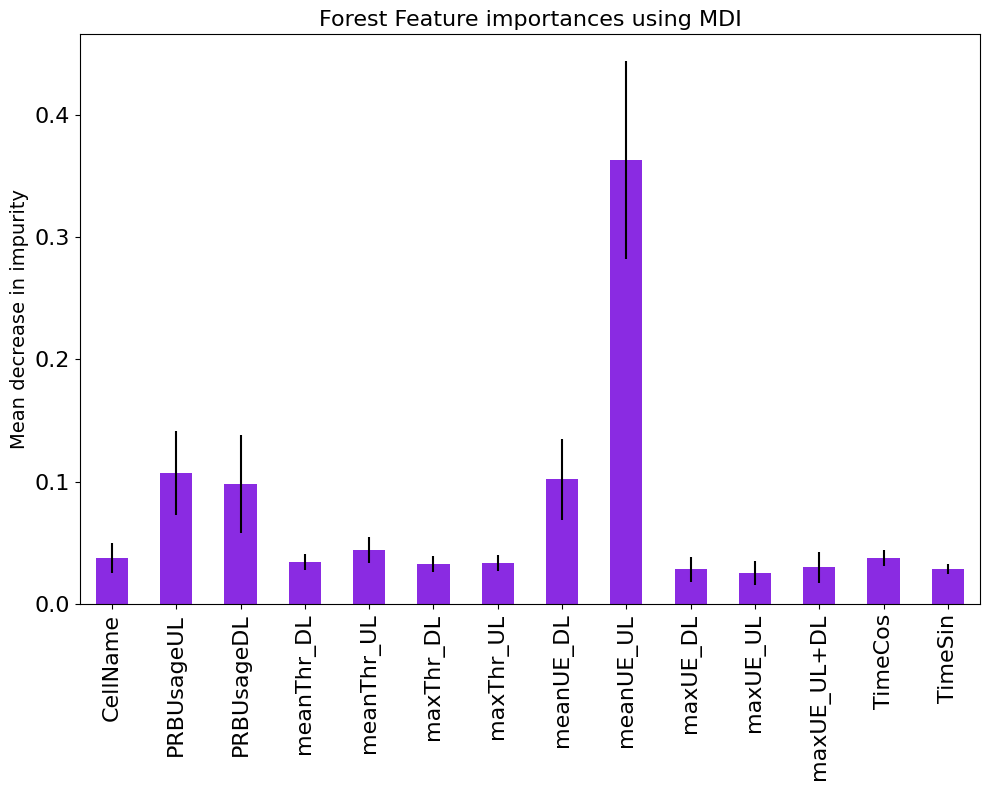

<ipython-input-11-9335496f63c3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator


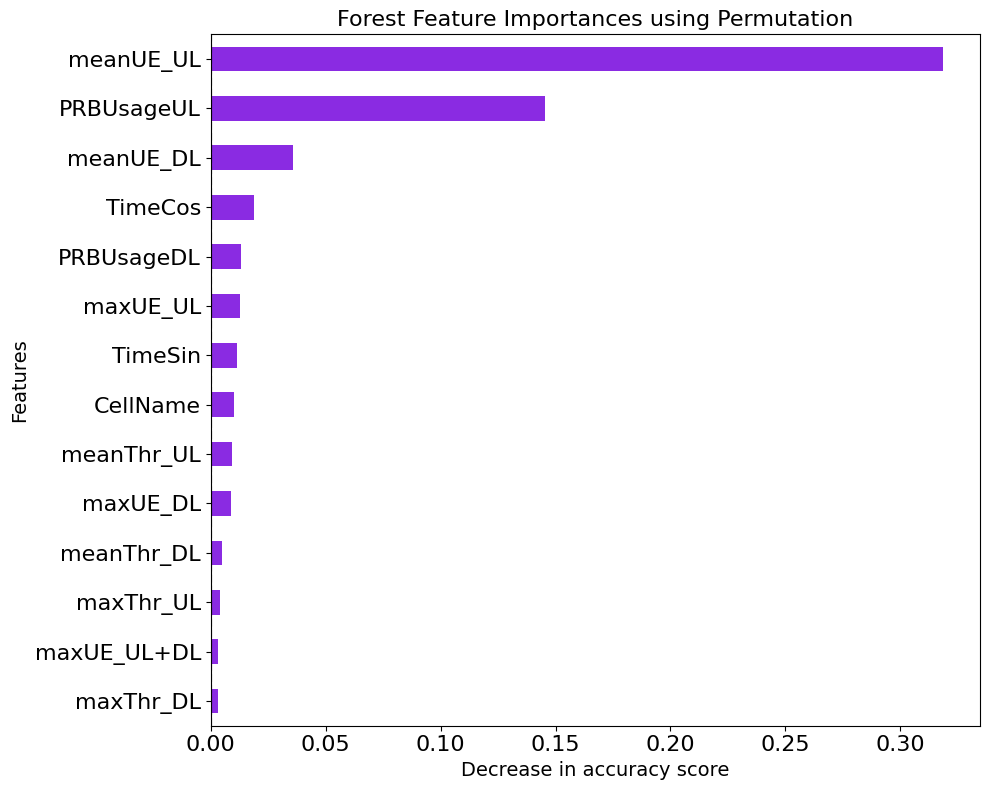

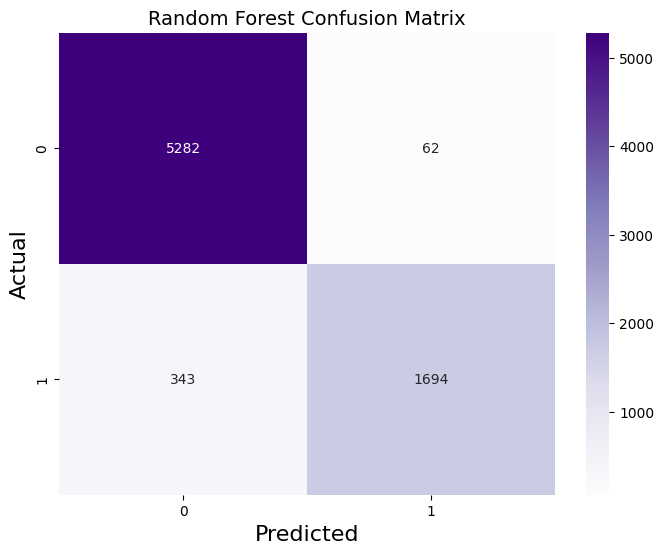

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

rf_model = RandomForestClassifier(n_estimators=600, random_state=42)
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
std = numpy.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X_train.columns))

fig, ax = plt.subplots(figsize=(10, 8))
forest_importances.plot.bar(yerr=std, ax=ax, color='blueviolet')
ax.set_title("Forest Feature importances using MDI", fontsize=16)
ax.set_ylabel("Mean decrease in impurity", fontsize=14)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
fig.tight_layout()
plt.show()

result = permutation_importance(
    rf_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
fig, ax = plt.subplots(figsize=(10, 8))
importances.mean().plot(kind='barh', ax=ax, color='blueviolet')
ax.set_title("Forest Feature Importances using Permutation", fontsize=16)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.figure.tight_layout()
plt.show()

y_pred = rf_model.predict(X_validation)
cm = confusion_matrix(y_validation, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Random Forest Confusion Matrix', fontdict={'fontsize': 14, 'fontweight': 'normal'})
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.show()

**2. Autoencoder**

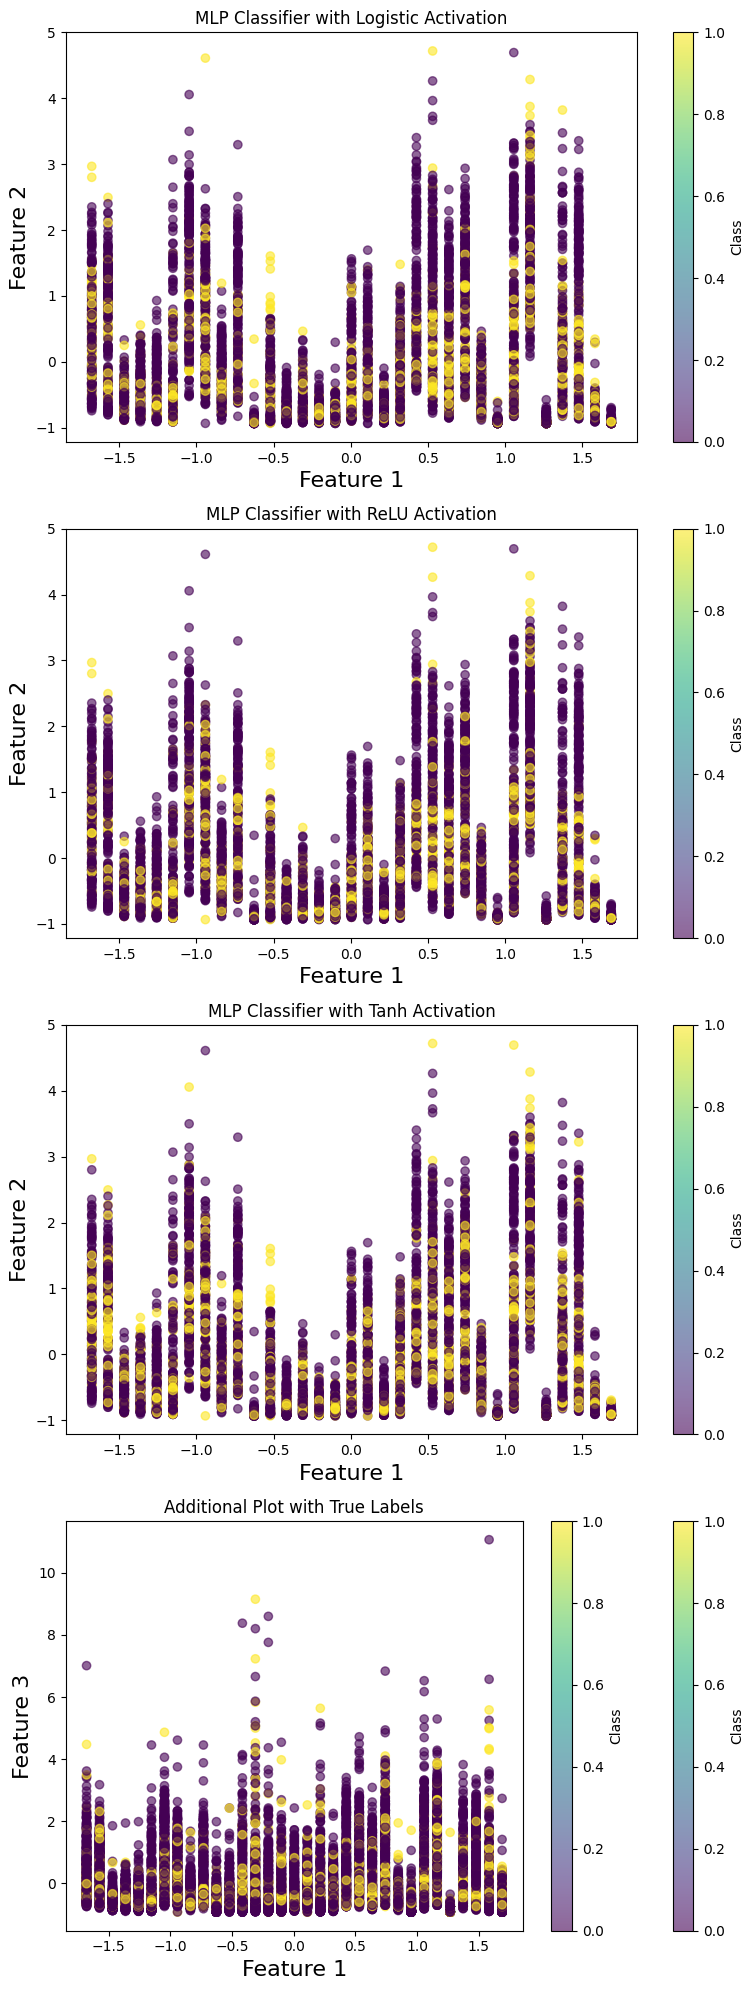

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
feature1_index = 0
feature2_index = 1
feature3_index = 2

mlp_log = MLPClassifier(hidden_layer_sizes=(100, 50, 25, 5), activation='logistic', random_state=42, max_iter=1000)
mlp_log.fit(X_train_scaled, y_train)
y_pred_log = mlp_log.predict(X_validation_scaled)

mlp_relu = MLPClassifier(hidden_layer_sizes=(100, 50, 25, 5), activation='relu', random_state=42, max_iter=1000)
mlp_relu.fit(X_train_scaled, y_train)
y_pred_relu = mlp_relu.predict(X_validation_scaled)

mlp_tanh = MLPClassifier(hidden_layer_sizes=(100, 50, 25, 5), activation='tanh', random_state=42, max_iter=1000)
mlp_tanh.fit(X_train_scaled, y_train)
y_pred_tanh = mlp_tanh.predict(X_validation_scaled)

mlp_identity = MLPClassifier(hidden_layer_sizes=(100, 50, 25, 5), activation='identity', random_state=42, max_iter=1000)
mlp_identity.fit(X_train_scaled, y_train)
y_pred_identity = mlp_identity.predict(X_validation_scaled)

fig, axes = plt.subplots(4, 1, figsize=(8, 20))
activation_functions = ['Logistic', 'ReLU', 'Tanh', 'Identity']
models = [mlp_log, mlp_relu, mlp_tanh, mlp_identity]
predictions = [y_pred_log, y_pred_relu, y_pred_tanh, y_pred_identity]

for ax, model, prediction, activation_function in zip(axes, models, predictions, activation_functions):
    scatter = ax.scatter(X_validation_scaled[:, feature1_index], X_validation_scaled[:, feature2_index], c=prediction, cmap='viridis', alpha=0.6)
    ax.set_xlabel(f'Feature {feature1_index + 1}', fontsize=16)  # X eksenindeki yazı boyutu
    ax.set_ylabel(f'Feature {feature2_index + 1}', fontsize=16)  # Y eksenindeki yazı boyutu
    ax.set_title(f'MLP Classifier with {activation_function} Activation')
    legend = plt.colorbar(scatter, ax=ax)
    legend.set_label('Class')

scatter3 = plt.scatter(X_validation_scaled[:, feature1_index], X_validation_scaled[:, feature3_index], c=y_validation, cmap='viridis', alpha=0.6)
plt.xlabel(f'Feature {feature1_index + 1}', fontsize=16)  # X eksenindeki yazı boyutu
plt.ylabel(f'Feature {feature3_index + 1}', fontsize=16)  # Y eksenindeki yazı boyutu
plt.title('Additional Plot with True Labels')
legend3 = plt.colorbar(scatter3)
legend3.set_label('Class')

plt.tight_layout()
plt.show()

**3. Gini Feature Importance in Decision Tree**

Top Features for criterion 'gini': Index(['meanUE_UL', 'PRBUsageUL', 'PRBUsageDL', 'meanUE_DL', 'maxThr_DL',
       'TimeCos'],
      dtype='object')


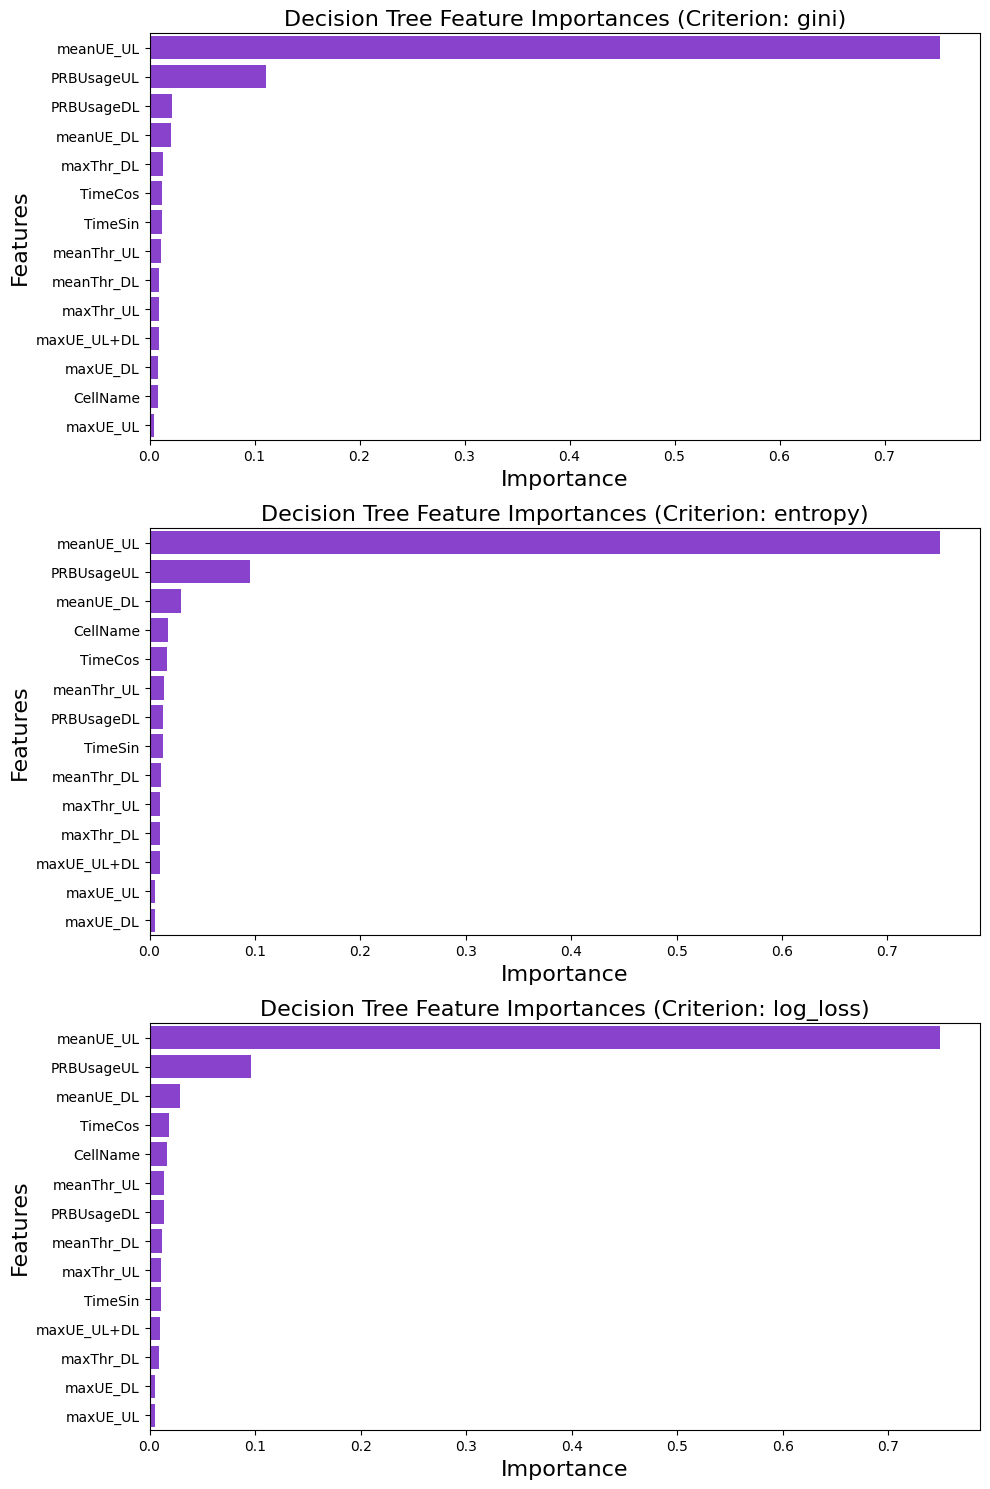

In [65]:
top_features_gini = None
criterions = ['gini', 'entropy', 'log_loss']

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

for i, criterion in enumerate(criterions):
    clf = DecisionTreeClassifier(criterion=criterion)
    clf.fit(X_train, y_train)

    feature_importances = clf.feature_importances_
    sorted_indices = feature_importances.argsort()[::-1]
    sorted_feature_names = X.columns[sorted_indices]
    sorted_importances = feature_importances[sorted_indices]

    sns.barplot(x=sorted_importances, y=sorted_feature_names, color='blueviolet', ax=axes[i])
    axes[i].set_title(f'Decision Tree Feature Importances (Criterion: {criterion})', fontsize=16)  # Başlık yazısının boyutunu ayarla
    axes[i].set_xlabel('Importance', fontsize=16)  # X eksen etiketini büyüt
    axes[i].set_ylabel('Features', fontsize=16)  # Y eksen etiketini büyüt

    if criterion == 'gini':
        top_features_gini = sorted_feature_names[:6]
        print(f"Top Features for criterion 'gini': {top_features_gini}")

plt.tight_layout()
plt.show()


**4. Permutation Feature Importance for Classification**


<ipython-input-5-34839ce58bb2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-5-34839ce58bb2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator


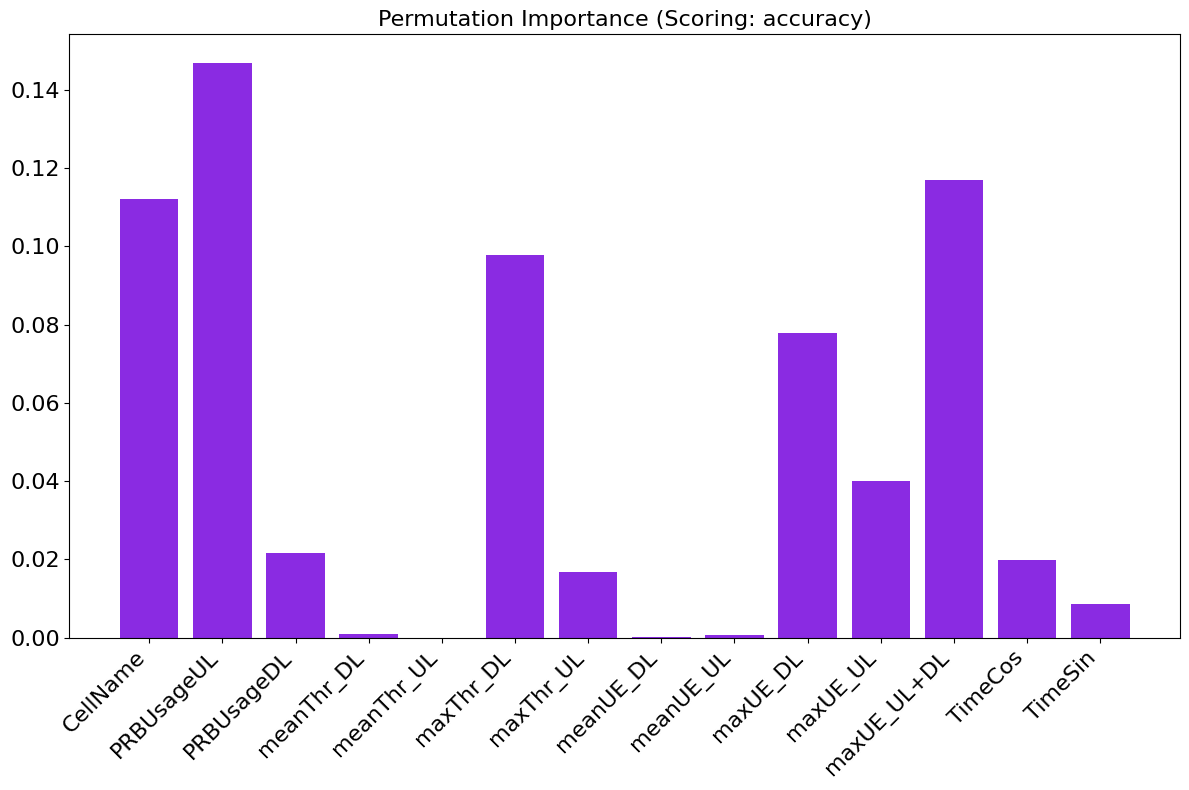

<ipython-input-5-34839ce58bb2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-5-34839ce58bb2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator


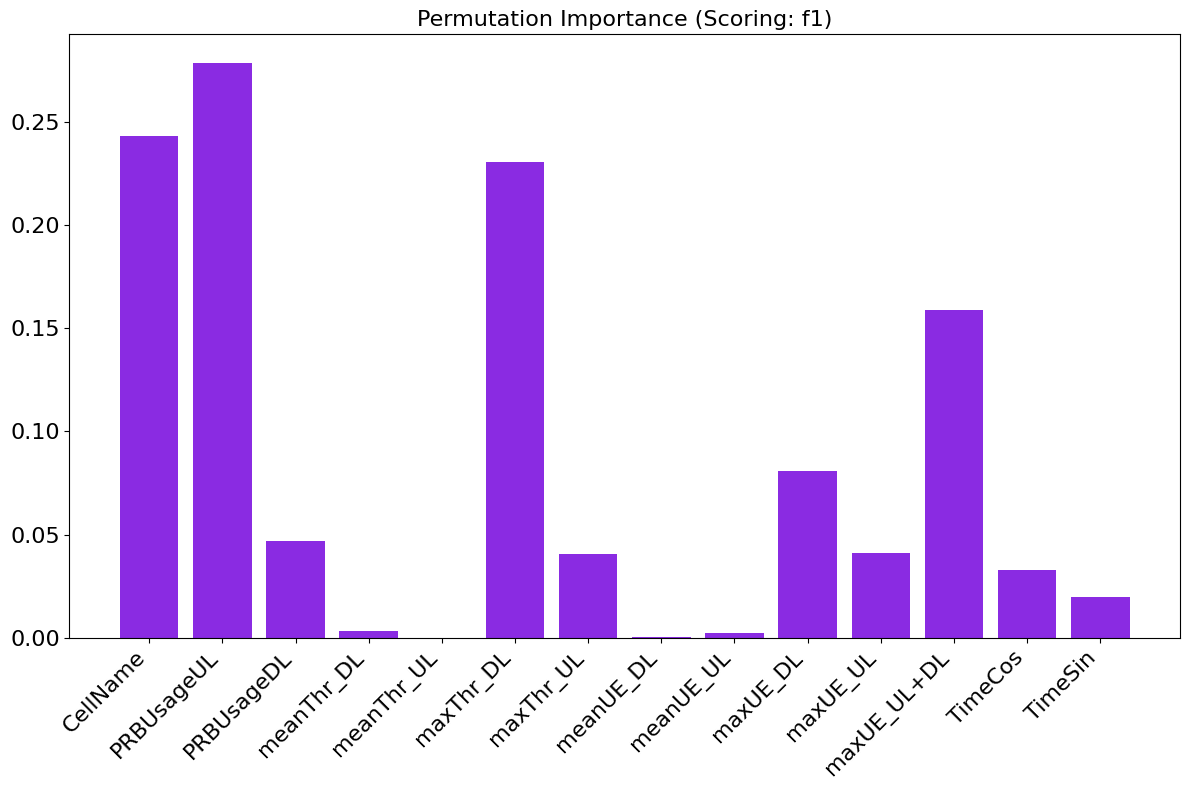

<ipython-input-5-34839ce58bb2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-5-34839ce58bb2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator


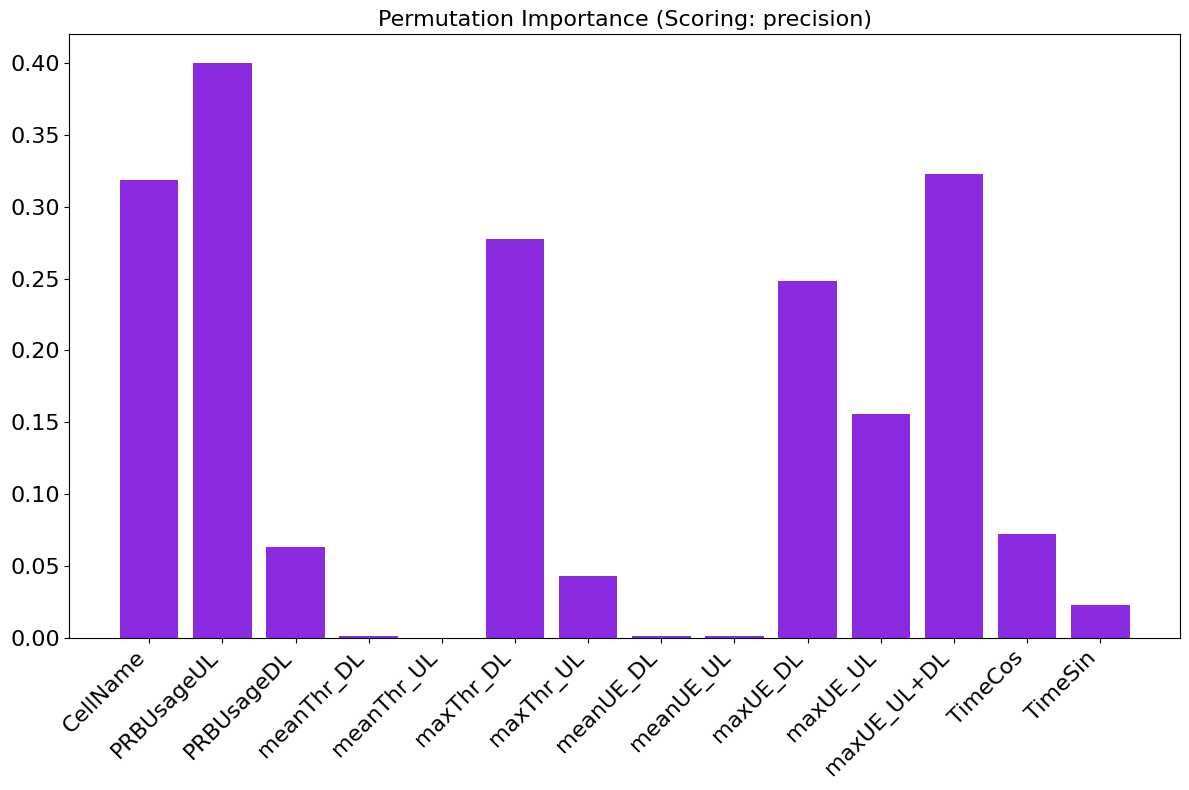

<ipython-input-5-34839ce58bb2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
<ipython-input-5-34839ce58bb2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator


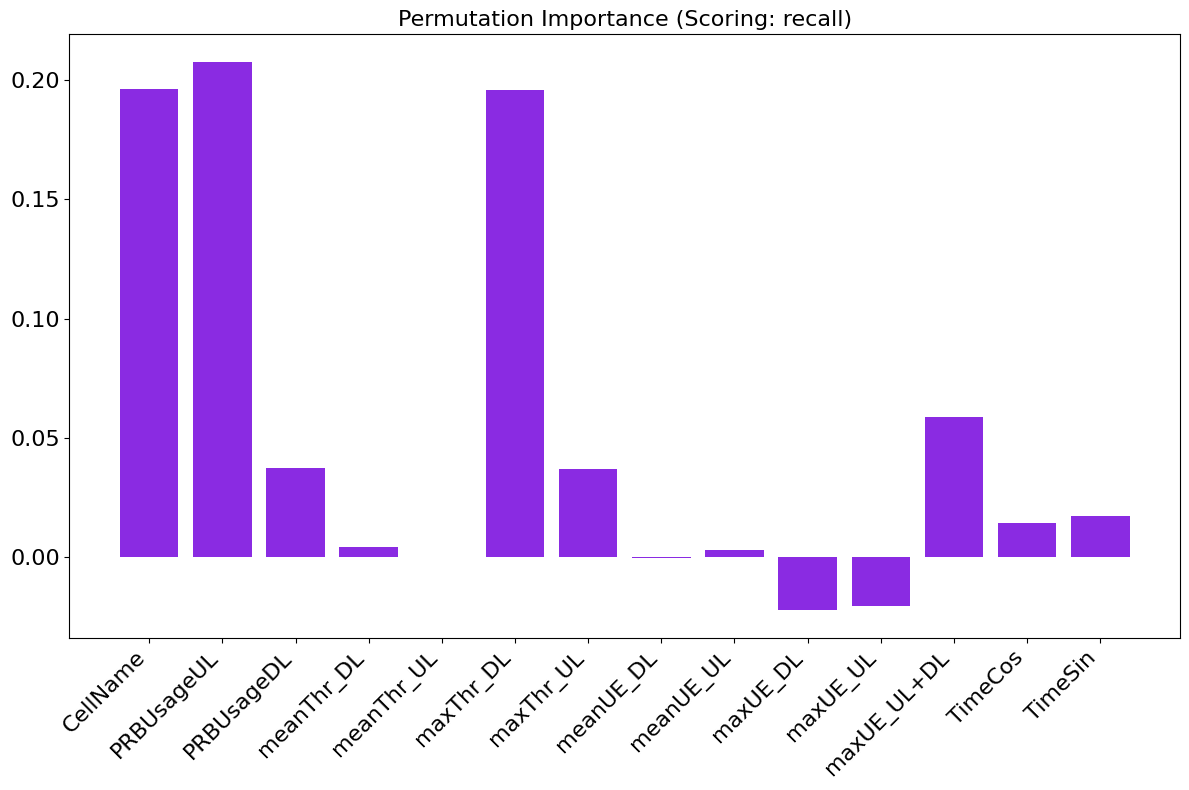

In [5]:
model = KNeighborsClassifier()

scoring_types = ['accuracy', 'f1', 'precision', 'recall']

for scoring_type in scoring_types:
    model.fit(X_train, y_train)
    results = permutation_importance(model, X_train, y_train, scoring=scoring_type, n_repeats=10, random_state=42, n_jobs=-1)
    importance_knn = results.importances_mean
    feature_names = X.columns
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(feature_names, importance_knn, color='blueviolet')
    ax.set_xticklabels(feature_names, rotation=45, ha="right", fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    ax.set_title(f'Permutation Importance (Scoring: {scoring_type})', fontsize=16)
    plt.tight_layout()
    plt.show()

**5. Gradient Boosting classifier**

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.


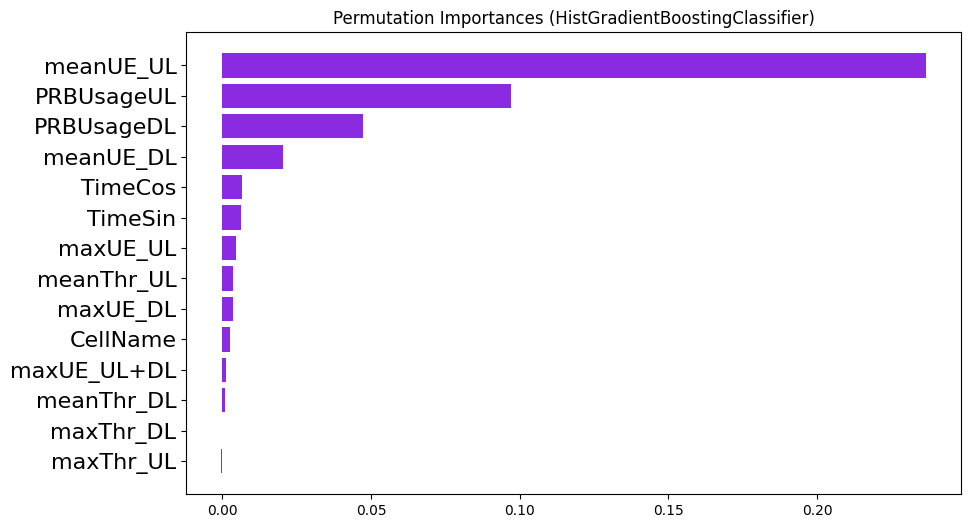

In [67]:
model = HistGradientBoostingClassifier(categorical_features=[True, False])
model = HistGradientBoostingClassifier(categorical_features=[0])
model = HistGradientBoostingClassifier(loss= 'binary_crossentropy',random_state=42)
model.fit(X_train, y_train)
result = permutation_importance(model, X_validation, y_validation, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx_gbc = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(sorted_idx_gbc)), result.importances_mean[sorted_idx_gbc], color='blueviolet')
ax.set_yticks(range(len(sorted_idx_gbc)))
ax.set_yticklabels(X.columns[sorted_idx_gbc], fontsize=16)
ax.set_title("Permutation Importances (HistGradientBoostingClassifier)")
plt.show()

  **6. SVC + RFECV**

  Sklearn sayfasındaki bir örnek temel alınarak hazırlanmıştır. ([kaynak](https://scikit-learn.org/0.24/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py ))

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
kernels = ['poly']
min_features_to_select =4
max_features_to_select = len(X_train.columns)
step = 1
n_jobs = -1

for kernel in kernels:
    print(f"\nKernel: {kernel}")


    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rfecv = RFECV(estimator=rf_model, step=step, cv=StratifiedKFold(2), scoring='accuracy', min_features_to_select=min_features_to_select, n_jobs=n_jobs)
    rfecv.fit(X_train_scaled, y_train)


    print("Optimal number of features : %d" % rfecv.n_features_)
    selected_features_svcrfecv = X_train.columns[rfecv.support_]
    print("Selected features:", selected_features_svcrfecv)

    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of features selected", fontsize=14)
    plt.ylabel("Cross validation score (nb of correct classifications)", fontsize=14)
    plt.plot(range(min_features_to_select, max_features_to_select + 1), rfecv.cv_results_["mean_test_score"], label=f"Kernel: {kernel}")
    plt.xticks(range(min_features_to_select, min_features_to_select + len(rfecv.cv_results_["mean_test_score"])), fontsize=14)
    plt.title(f"Kernel: {kernel}", fontsize=14)
    plt.legend()
    plt.show()

**7. Sequential Forward - Backward  Feature Selection**

*SFS differs from RFE and SelectFromModel in that it does not require the underlying model to expose a coef_ or feature_importances_ attribute. It may however be slower considering that more models need to be evaluated, compared to the other approaches. For example in backward selection, the iteration going from m features to m - 1 features using k-fold cross-validation requires fitting m * k models, while RFE would require only a single fit, and SelectFromModel always just does a single fit and requires no iterations.*
[kaynak](https://scikit-learn.org/0.24/modules/feature_selection.html#sequential-feature-selection)

[kod kaynak](https://scikit-learn.org/0.24/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py)




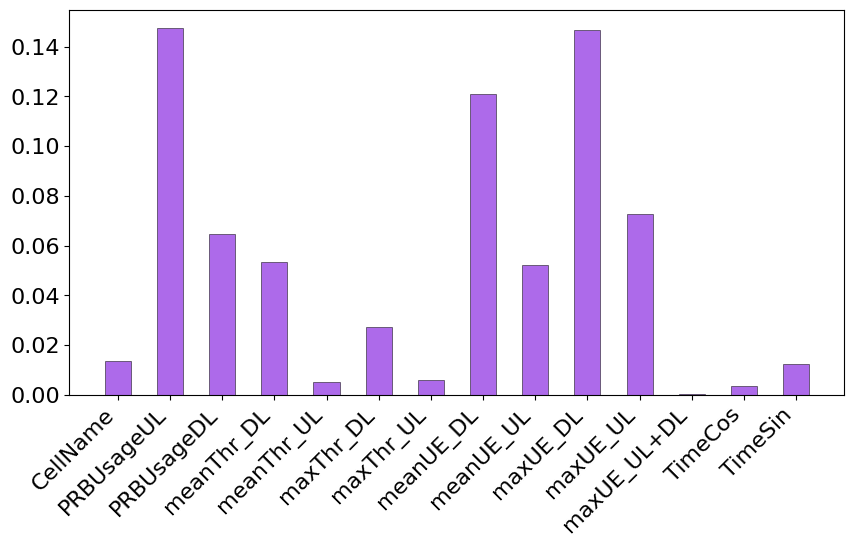

Features selected by forward sequential selection: ['PRBUsageUL' 'meanUE_DL' 'meanUE_UL' 'maxUE_UL+DL']
Done in 75.354s
Features selected by backward sequential selection: ['PRBUsageUL' 'meanUE_DL' 'meanUE_UL' 'maxUE_UL+DL']
Done in 190.625s


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lasso = LassoCV().fit(X_scaled, y)
importance = numpy.abs(lasso.coef_)
feature_names = numpy.array(X.columns)
plt.figure(figsize=(10, 5))
bars = plt.bar(height=importance, x=feature_names, color='blueviolet', width=0.5)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
for bar in bars:
    bar.set_color('blueviolet')
    bar.set_alpha(0.7)
    bar.set_edgecolor('black')
    bar.set_linewidth(0.5)
plt.show()
tic_fwd = time()
sfs_forward = SequentialFeatureSelector(lasso, n_features_to_select=4, direction='forward').fit(X_scaled, y)
toc_fwd = time()
tic_bwd = time()
sfs_backward = SequentialFeatureSelector(lasso, n_features_to_select=4, direction='backward').fit(X_scaled, y)
toc_bwd = time()
print("Features selected by forward sequential selection: "
      f"{feature_names[sfs_forward.get_support()]}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features selected by backward sequential selection: "
      f"{feature_names[sfs_backward.get_support()]}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")


**8. ANOVA**

[kaynak kod](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_anova.html)

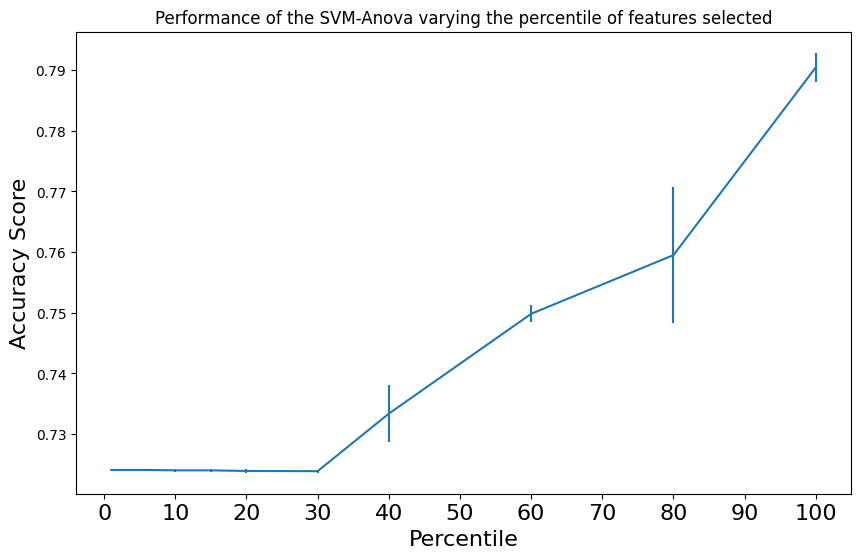

In [ ]:
clf = Pipeline([
    ("anova", SelectPercentile(f_classif)),
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel = 'rbf', C= 1.0, gamma="auto")),
])
score_means = []
score_stds = []
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X_train_, y_train_)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
plt.figure(figsize=(10, 6))
plt.errorbar(percentiles, score_means, numpy.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(numpy.linspace(0, 100, 11, endpoint=True) ,fontsize=16)
plt.xlabel("Percentile", fontsize=16)
plt.ylabel("Accuracy Score", fontsize=16)
plt.axis("tight")
plt.show()

**9. Kendall's Test**

[kaynak kod](https://neptune.ai/blog/feature-selection-methods)

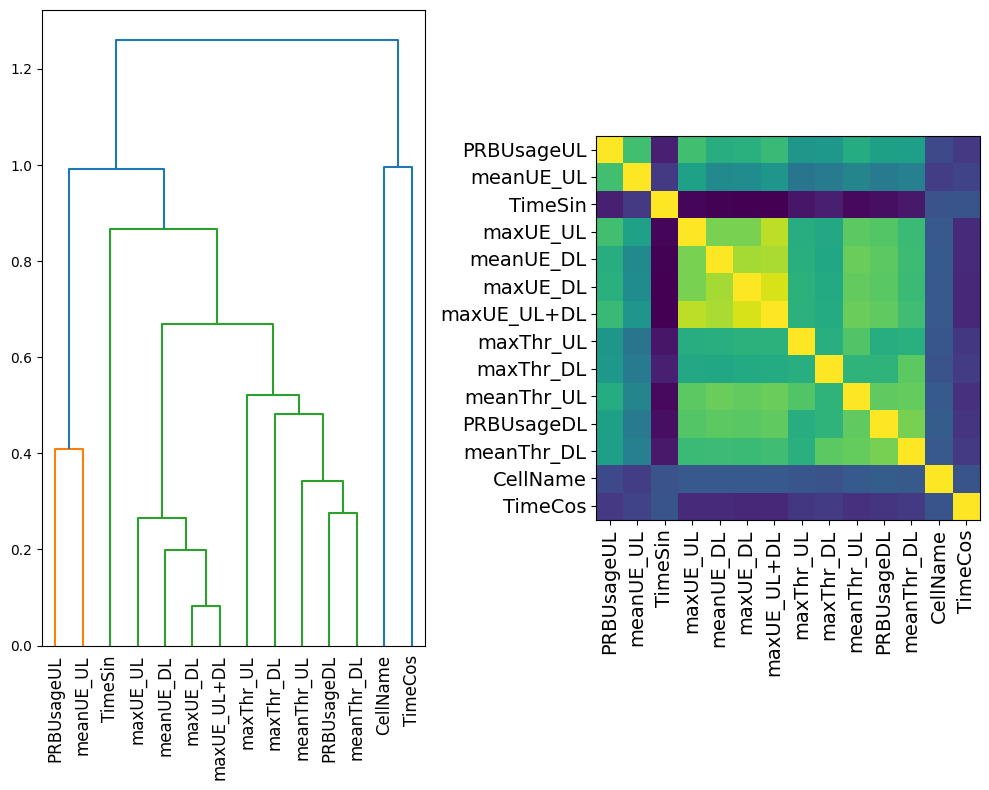

Selected Features based on Kendall's Tau Correlation: ['PRBUsageDL', 'meanThr_DL', 'meanUE_DL', 'maxUE_DL', 'maxUE_UL', 'maxUE_UL+DL']


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
corr = pd.DataFrame(index=X_train.columns, columns=X_train.columns)
corr = corr.astype(float)

for col1, col2 in combinations(X_train.columns, 2):
    tau, _ = kendalltau(X_train[col1], X_train[col2])
    corr.loc[col1, col2] = tau
    corr.loc[col2, col1] = tau

corr = (corr.values + corr.values.T) / 2
numpy.fill_diagonal(corr, 1)
distance_matrix = 1 - numpy.abs(corr)
dist_linkage = hierarchy.ward(distance.squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = numpy.arange(0, len(dendro["ivl"]))
ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical",fontsize=14)
ax2.set_yticklabels(dendro["ivl"],fontsize=14)
_ = fig.tight_layout()
plt.show()

threshold = 0.7
selected_features_kendall = []
for col1, col2 in combinations(X_train.columns, 2):
    tau, _ = kendalltau(X_train[col1], X_train[col2])
    if abs(tau) > threshold:
        if col1 not in selected_features_kendall:
            selected_features_kendall.append(col1)
        if col2 not in selected_features_kendall:
            selected_features_kendall.append(col2)

print("Selected Features based on Kendall's Tau Correlation:", selected_features_kendall)


**10 . Univariate Feature Selection**

*The reason these tests are called univariate tests is that they do not look at all the features collectively. In particular, it does not take into account the interaction between features. Instead, it looks at each feature separately and determines whether there is a significant relationship between that feature and the target.*[kaynak](https://towardsdatascience.com/mistakes-in-applying-univariate-feature-selection-methods-34c43ce8b93d)

Classification accuracy without selecting features: 0.722
Selected features from SVM weights: Index(['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL', 'maxThr_DL', 'meanUE_DL',
       'maxUE_UL'],
      dtype='object')
Classification accuracy after univariate feature selection: 0.724


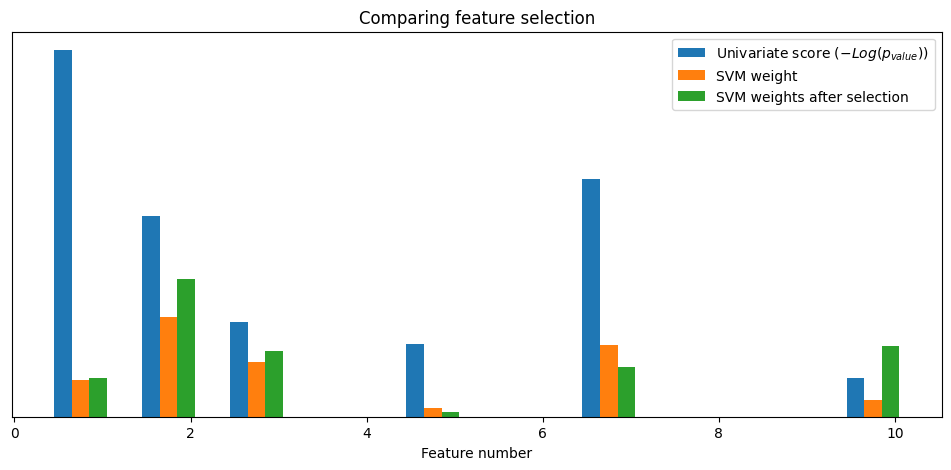

In [ ]:
X_indices = numpy.arange(X_train.shape[-1])
selector = SelectKBest(f_classif, k=6)
selector.fit(X_train, y_train)
scores = -numpy.log10(selector.pvalues_)
scores /= scores.max()
plt.figure(figsize=(12, 5))

plt.bar(X_indices[selector.get_support()] - .45, scores[selector.get_support()], width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

feature_names = X.columns
clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_train, y_train)))
svm_weights = numpy.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()
selected_indices = numpy.where(selector.get_support())[0]
selected_feature_names_svm = feature_names[selected_indices]
print("Selected features from SVM weights:", selected_feature_names_svm)

plt.bar(selected_indices - .25, svm_weights[selected_indices], width=.2, label='SVM weight')

clf_selected = make_pipeline(
    SelectKBest(f_classif, k=6), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(X_train, y_train)))
svm_weights_selected = numpy.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()
plt.bar(X_indices[selected_indices] - .05, svm_weights_selected, width=.2, label='SVM weights after selection')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()


##  3. Classification

###**1.MLP**

* [Buradaki verilere](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html) göre alpha değerinin çok büyümesi sınıflandırmayı düşürürken küçük değerler için daha doğru sonuçlar vermektedir.  0.00001 olrak karar verilmiştir.
* relu ve logistic activation parametreleri karşılaştırıldığnda başabaş bir doğruluk değeri verse de hidden layer değerine göre logistic daha öne geçmiştir. identity ise en üşük doğruluk oranını vermiştir.
* max_iter (adam kullanıldığı için epoch olarak görülüyor) test yükselirken validation düşüşe geçtiği anda kesilecek değer olarak karar verilecektir. 512 seçildi, daha ilerisinde doğruluk artmıyor.
* batch_size 64 değerinde en büyük doğruluk görüldü.
* tol, beta_* parametrelerinin bir etkisi olmadı.



**relu**:
```
Training Accuracy: 0.8575
Validation Accuracy: 0.8347
```

tanh
```
Training Accuracy: 0.8609
Validation Accuracy: 0.8301
```

 logistic
```
Training Accuracy: 0.8678
Validation Accuracy: 0.8339
```


identity
```
Training Accuracy: 0.7232
Validation Accuracy: 0.7208
```
ortak:

```
    hidden_layer_sizes=(100,),
    solver='adam',               
    batch_size=32,               
    learning_rate='constant',    
    max_iter=1000,               
    random_state=42

```

----
logistic:


```
    hidden_layer_sizes=(100, 50),
    solver='adam',
    batch_size=32,
    learning_rate='constant',
    max_iter=1000,
    random_state=42

  Training Accuracy: 0.9452
  Validation Accuracy: 0.8134
```


```
  hidden_layer_sizes=(100, 50, 25),
  solver='adam',
  batch_size=32,
  learning_rate='constant',
  max_iter=1000,
  random_state=42

Training Accuracy: 0.9147
Validation Accuracy: 0.8328

```


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.


Training Accuracy: 0.8875
Training Recall: 0.7769
Training Precision: 0.8079
Training F1-score: 0.7921

Validation Accuracy: 0.8393
Validation Recall: 0.6750
Validation Precision: 0.7241
Validation F1-score: 0.6987


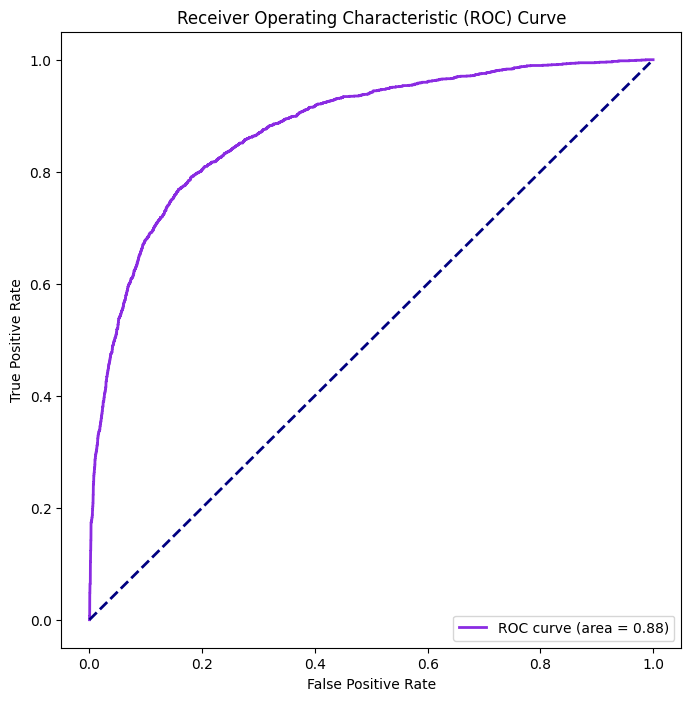

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_)
X_validation_scaled = scaler.transform(X_validation_)
X_test_scaled = scaler.transform(X_test)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,50,25),
    activation='logistic',
    solver='adam',
    batch_size=64,
    max_iter=512,
    alpha = 0.00001,
    random_state=42,
)

mlp_model.fit(X_train_scaled, y_train_)


train_predictions = mlp_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train_, train_predictions)
train_recall = recall_score(y_train_, train_predictions)
train_precision = precision_score(y_train_, train_predictions)
train_f1 = f1_score(y_train_, train_predictions)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training F1-score: {train_f1:.4f}")

validation_predictions = mlp_model.predict(X_validation_scaled)
validation_accuracy = accuracy_score(y_validation_, validation_predictions)
validation_recall = recall_score(y_validation_, validation_predictions)
validation_precision = precision_score(y_validation_, validation_predictions)
validation_f1 = f1_score(y_validation_, validation_predictions)

print(f"\nValidation Accuracy: {validation_accuracy:.4f}")
print(f"Validation Recall: {validation_recall:.4f}")
print(f"Validation Precision: {validation_precision:.4f}")
print(f"Validation F1-score: {validation_f1:.4f}")

fpr, tpr, thresholds = roc_curve(y_validation_, mlp_model.predict_proba(X_validation_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


***Feature Selection with Forest Importance Permutation + MLP***

['meanUE_UL', 'PRBUsageUL', 'meanUE_DL', 'PRBUsageDL', 'meanThr_UL', 'TimeCos']
Training Accuracy: 0.8030
Validation Accuracy: 0.7914
Validation F1 Score: 0.5539
Validation Recall: 0.4693
Validation recision: 0.6756


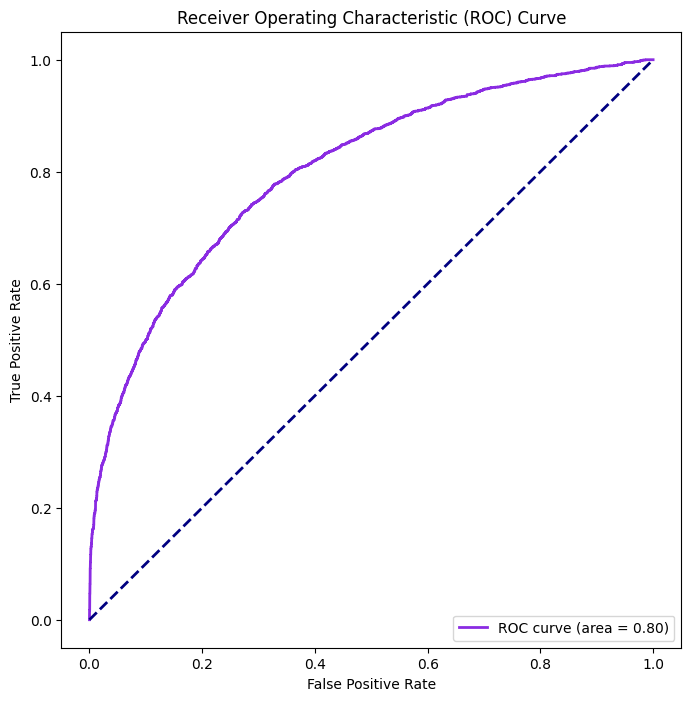

In [ ]:
top_features = forest_importances.sort_values(ascending=False).index[:6]
selected_features = list(top_features)
print(selected_features)
X_train_top_features = X_train[selected_features]
X_validation_top_features = X_validation[selected_features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top_features)
X_validation_scaled = scaler.transform(X_validation_top_features)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='logistic',
    solver='adam',
    batch_size=64,
    max_iter=512,
    alpha=0.00001,
    random_state=42,
)
mlp_model.fit(X_train_scaled, y_train)
train_predictions = mlp_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")

validation_predictions = mlp_model.predict(X_validation_scaled)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

# F1 Score, Recall ve Precision hesapla
f1 = f1_score(y_validation, validation_predictions)
recall = recall_score(y_validation, validation_predictions)
precision = precision_score(y_validation, validation_predictions)

print(f"Validation F1 Score: {f1:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation recision: {precision:.4f}")

# ROC Curve çizimi
fpr, tpr, thresholds = roc_curve(y_validation, mlp_model.predict_proba(X_validation_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



***2. SVC + RFECV + MLP***

Index(['PRBUsageUL', 'PRBUsageDL', 'meanThr_UL', 'meanUE_DL', 'meanUE_UL',
       'TimeCos'],
      dtype='object')
Training Accuracy: 0.8314
Training Precision: 0.7691
Training Recall: 0.5557
Training F1 Score: 0.6452
Validation Accuracy: 0.8002
Validation Precision: 0.6909
Validation Recall: 0.4993
Validation F1 Score: 0.5797


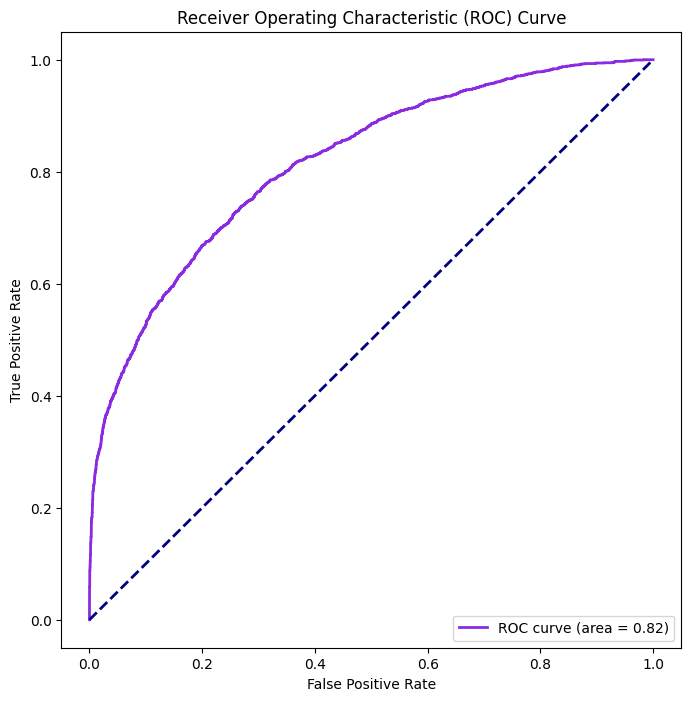

In [ ]:
selected_features = X_train.columns[rfecv.support_]
print(selected_features)
X_train_selected = X_train[selected_features]
X_validation_selected = X_validation[selected_features]
scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_validation_selected_scaled = scaler.transform(X_validation_selected)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='logistic',
    solver='adam',
    batch_size=64,
    max_iter=1024,
    alpha=0.00001,
    random_state=42,
)
mlp_model.fit(X_train_selected_scaled, y_train)
train_predictions = mlp_model.predict(X_train_selected_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)
precision_train = precision_score(y_train, train_predictions)
recall_train = recall_score(y_train, train_predictions)
f1_train = f1_score(y_train, train_predictions)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")
print(f"Training F1 Score: {f1_train:.4f}")

validation_predictions = mlp_model.predict(X_validation_selected_scaled)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
precision_validation = precision_score(y_validation, validation_predictions)
recall_validation = recall_score(y_validation, validation_predictions)
f1_validation = f1_score(y_validation, validation_predictions)

print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Validation Precision: {precision_validation:.4f}")
print(f"Validation Recall: {recall_validation:.4f}")
print(f"Validation F1 Score: {f1_validation:.4f}")

fpr, tpr, thresholds = roc_curve(y_validation, mlp_model.predict_proba(X_validation_selected_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


***Feature Selection KNeightbors Permutation +  MLP***

Index(['PRBUsageUL', 'CellName', 'maxThr_DL', 'maxUE_UL+DL', 'PRBUsageDL',
       'maxThr_UL'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.


Training Accuracy: 0.7888
Training Precision: 0.6711
Training Recall: 0.4600
Training F1 Score: 0.5459
Validation Accuracy: 0.7674
Validation Precision: 0.6119
Validation Recall: 0.4296
Validation F1 Score: 0.5048


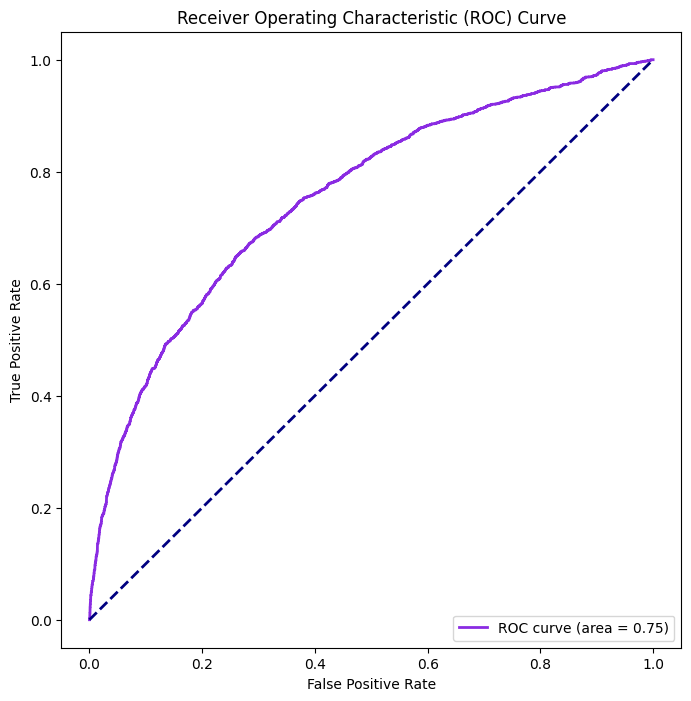

In [ ]:
top_features = feature_names[importance_values.argsort()[-6:][::-1]]
print(top_features)
X_train_top_features = X_train[top_features]
X_validation_top_features = X_validation[top_features]
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='logistic',
    solver='adam',
    batch_size=64,
    max_iter=512,
    alpha=0.00001,
    random_state=42,
)
mlp_model.fit(X_train_top_features, y_train)
train_predictions = mlp_model.predict(X_train_top_features)
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")

validation_predictions = mlp_model.predict(X_validation_top_features)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
validation_precision = precision_score(y_validation, validation_predictions)
validation_recall = recall_score(y_validation, validation_predictions)
validation_f1 = f1_score(y_validation, validation_predictions)

print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Validation Precision: {validation_precision:.4f}")
print(f"Validation Recall: {validation_recall:.4f}")
print(f"Validation F1 Score: {validation_f1:.4f}")

fpr, tpr, thresholds = roc_curve(y_validation, mlp_model.predict_proba(X_validation_top_features)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


***Feature Selection with Sequential Feature Selection (B+F) + MLP***

Top 6 Lasso Selected Features: ['meanThr_DL' 'PRBUsageDL' 'maxUE_UL' 'meanUE_DL' 'maxUE_DL' 'PRBUsageUL']
Training Accuracy: 0.8224
Training Precision: 0.7634
Training Recall: 0.5164
Training F1 Score: 0.6160
Validation Accuracy: 0.5226
Validation Precision: 0.3228
Validation Recall: 0.6647
Validation F1 Score: 0.4345


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names


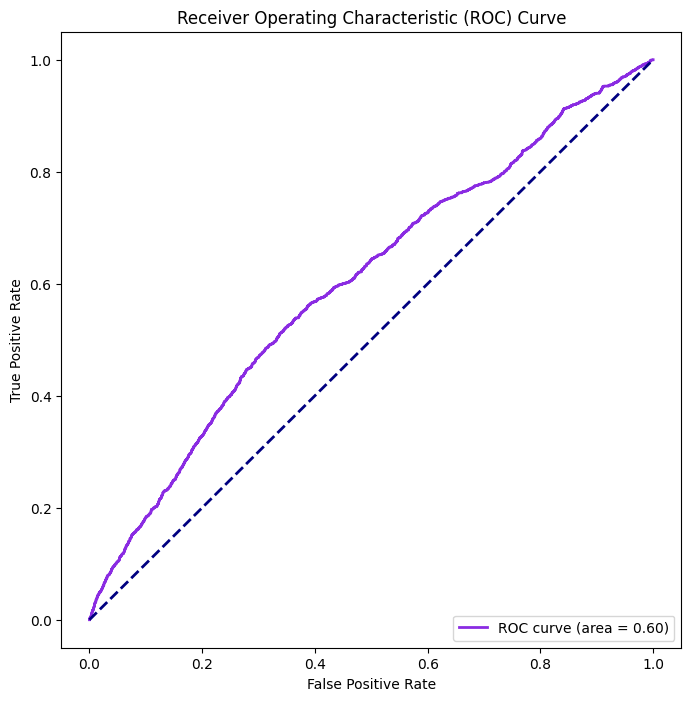

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lasso = LassoCV().fit(X_scaled, y)
importance = numpy.abs(lasso.coef_)
feature_names = numpy.array(X.columns)
lasso_selected_indices = numpy.argsort(importance)[-6:]
lasso_selected_features = feature_names[lasso_selected_indices]
print("Top 6 Lasso Selected Features:", lasso_selected_features)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='logistic',
    solver='adam',
    batch_size=64,
    max_iter=512,
    alpha=0.00001,
    random_state=42,
)

X_selected = X[lasso_selected_features]
X_selected_scaled = scaler.fit_transform(X_selected)
mlp_model.fit(X_selected_scaled, y)

train_predictions = mlp_model.predict(X_selected_scaled)
train_accuracy = accuracy_score(y, train_predictions)
train_precision = precision_score(y, train_predictions)
train_recall = recall_score(y, train_predictions)
train_f1 = f1_score(y, train_predictions)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")

y_validation_np = y_validation.to_numpy().reshape(-1, 1)
validation_predictions = mlp_model.predict(X_validation[lasso_selected_features])
validation_accuracy = accuracy_score(y_validation_np, validation_predictions)
validation_precision = precision_score(y_validation_np, validation_predictions)
validation_recall = recall_score(y_validation_np, validation_predictions)
validation_f1 = f1_score(y_validation_np, validation_predictions)

print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Validation Precision: {validation_precision:.4f}")
print(f"Validation Recall: {validation_recall:.4f}")
print(f"Validation F1 Score: {validation_f1:.4f}")

fpr, tpr, thresholds = roc_curve(y_validation_np, mlp_model.predict_proba(X_validation[lasso_selected_features])[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

***Kendall Test + MLP***

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names


Training Accuracy: 0.8000
Training Precision: 0.7504
Training Recall: 0.4122
Training F1 Score: 0.5321
Validation Accuracy: 0.7869
Validation Precision: 0.7125
Validation Recall: 0.3819
Validation F1 Score: 0.4973


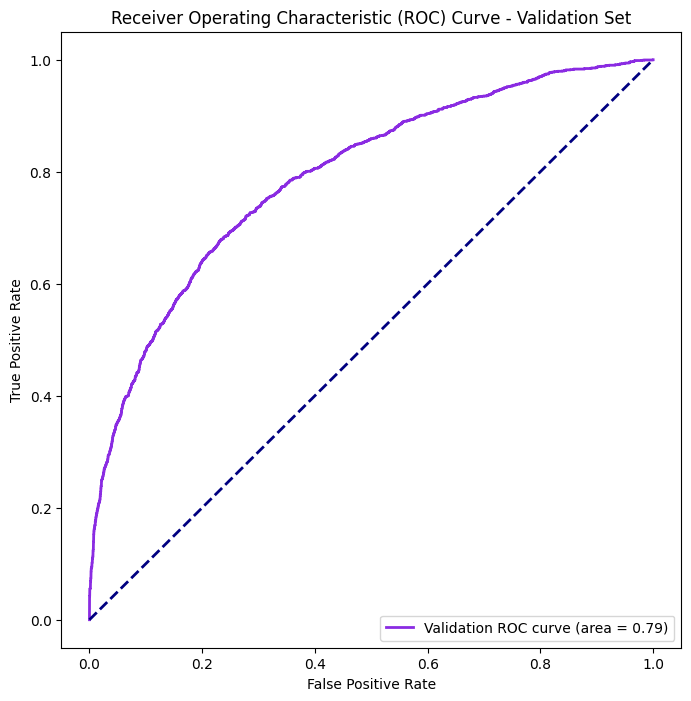

In [ ]:
X_train_selected_kendall = X_train[selected_features_kendall]
X_validation_selected_kendall = X_validation[selected_features_kendall]
X_test_columns = X.columns.tolist()
selected_features_indices = [X_test_columns.index(col) for col in selected_features_kendall]
X_test_selected_kendall = X_test[:, selected_features_indices]
scaler_kendall = StandardScaler()
X_train_selected_scaled_kendall = scaler_kendall.fit_transform(X_train_selected_kendall)
X_validation_selected_scaled_kendall = scaler_kendall.transform(X_validation_selected_kendall)
X_test_selected_scaled_kendall = scaler_kendall.transform(X_test_selected_kendall)

mlp_model_kendall = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='logistic',
    solver='adam',
    batch_size=64,
    max_iter=512,
    alpha=0.00001,
    random_state=42,
)

mlp_model_kendall.fit(X_train_selected_scaled_kendall, y_train)
train_predictions_kendall = mlp_model_kendall.predict(X_train_selected_scaled_kendall)
train_accuracy_kendall = accuracy_score(y_train, train_predictions_kendall)
train_precision_kendall = precision_score(y_train, train_predictions_kendall)
train_recall_kendall = recall_score(y_train, train_predictions_kendall)
train_f1_kendall = f1_score(y_train, train_predictions_kendall)

print(f"Training Accuracy: {train_accuracy_kendall:.4f}")
print(f"Training Precision: {train_precision_kendall:.4f}")
print(f"Training Recall: {train_recall_kendall:.4f}")
print(f"Training F1 Score: {train_f1_kendall:.4f}")

validation_predictions_kendall = mlp_model_kendall.predict(X_validation_selected_scaled_kendall)
validation_accuracy_kendall = accuracy_score(y_validation, validation_predictions_kendall)
validation_precision_kendall = precision_score(y_validation, validation_predictions_kendall)
validation_recall_kendall = recall_score(y_validation, validation_predictions_kendall)
validation_f1_kendall = f1_score(y_validation, validation_predictions_kendall)

print(f"Validation Accuracy: {validation_accuracy_kendall:.4f}")
print(f"Validation Precision: {validation_precision_kendall:.4f}")
print(f"Validation Recall: {validation_recall_kendall:.4f}")
print(f"Validation F1 Score: {validation_f1_kendall:.4f}")

fpr_test_kendall, tpr_test_kendall, thresholds_test_kendall = roc_curve(
    y_validation, mlp_model_kendall.predict_proba(X_validation_selected_scaled_kendall)[:, 1]
)
roc_auc_test_kendall = auc(fpr_test_kendall, tpr_test_kendall)

plt.figure(figsize=(8, 8))
plt.plot(fpr_test_kendall, tpr_test_kendall, color='blueviolet', lw=2, label=f'Validation ROC curve (area = {roc_auc_test_kendall:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend(loc='lower right')
plt.show()


###**2. SVM**

***SVM + KNeighbour Classifier with Permutation Feature Selection***

*poly*

Top 5 KNN Selected Features: Index(['PRBUsageUL', 'CellName', 'maxThr_DL', 'maxUE_UL+DL', 'PRBUsageDL',
       'maxThr_UL'],
      dtype='object')
Training Accuracy (KNN): 0.8199
Training Precision (KNN): 0.7508
Training Recall (KNN): 0.5196
Training F1 Score (KNN): 0.6142
Validation Accuracy (KNN): 0.7450
Validation Precision (KNN): 0.5556
Validation Recall (KNN): 0.3800
Validation F1 Score (KNN): 0.4513


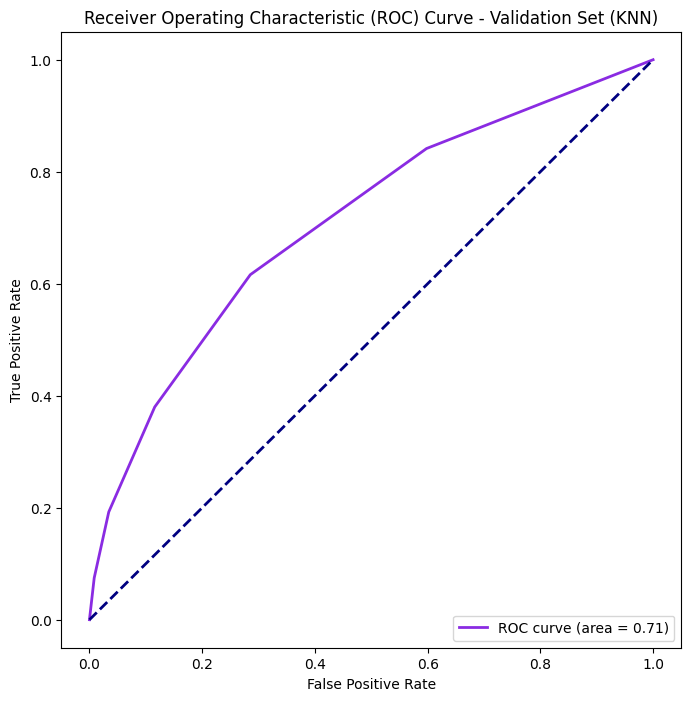

In [ ]:
knn_selected_indices = importance_knn.argsort()[-6:][::-1]
knn_selected_features = feature_names[knn_selected_indices]
print("Top 5 KNN Selected Features:", knn_selected_features)

X_train_selected_knn = X_train[knn_selected_features]
X_validation_selected_knn = X_validation[knn_selected_features]

scaler = StandardScaler()
X_train_selected_scaled_knn = scaler.fit_transform(X_train_selected_knn)
X_validation_selected_scaled_knn = scaler.transform(X_validation_selected_knn)

model_knn = KNeighborsClassifier(weights='uniform', algorithm='auto', n_neighbors=5)
model_knn.fit(X_train_selected_scaled_knn, y_train)

train_predictions_knn = model_knn.predict(X_train_selected_scaled_knn)
train_accuracy_knn = accuracy_score(y_train, train_predictions_knn)
train_precision_knn = precision_score(y_train, train_predictions_knn)
train_recall_knn = recall_score(y_train, train_predictions_knn)
train_f1_knn = f1_score(y_train, train_predictions_knn)

print(f"Training Accuracy (KNN): {train_accuracy_knn:.4f}")
print(f"Training Precision (KNN): {train_precision_knn:.4f}")
print(f"Training Recall (KNN): {train_recall_knn:.4f}")
print(f"Training F1 Score (KNN): {train_f1_knn:.4f}")

validation_predictions_knn = model_knn.predict(X_validation_selected_scaled_knn)
validation_accuracy_knn = accuracy_score(y_validation, validation_predictions_knn)
validation_precision_knn = precision_score(y_validation, validation_predictions_knn)
validation_recall_knn = recall_score(y_validation, validation_predictions_knn)
validation_f1_knn = f1_score(y_validation, validation_predictions_knn)

print(f"Validation Accuracy (KNN): {validation_accuracy_knn:.4f}")
print(f"Validation Precision (KNN): {validation_precision_knn:.4f}")
print(f"Validation Recall (KNN): {validation_recall_knn:.4f}")
print(f"Validation F1 Score (KNN): {validation_f1_knn:.4f}")

fpr_val, tpr_val, thresholds_val = roc_curve(y_validation, model_knn.predict_proba(X_validation_selected_scaled_knn)[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set (KNN)')
plt.legend(loc='lower right')
plt.show()


*rbf*

Top 5 KNN Selected Features: ['PRBUsageUL' 'CellName' 'maxThr_DL' 'maxUE_UL+DL' 'PRBUsageDL'
 'maxThr_UL']
Training Accuracy: 0.7242
Training Precision: 1.0000
Training Recall: 0.0004
Training F1 Score: 0.0007
Validation Accuracy: 0.7240
Validation Precision: 1.0000
Validation Recall: 0.0000
Validation F1 Score: 0.0000


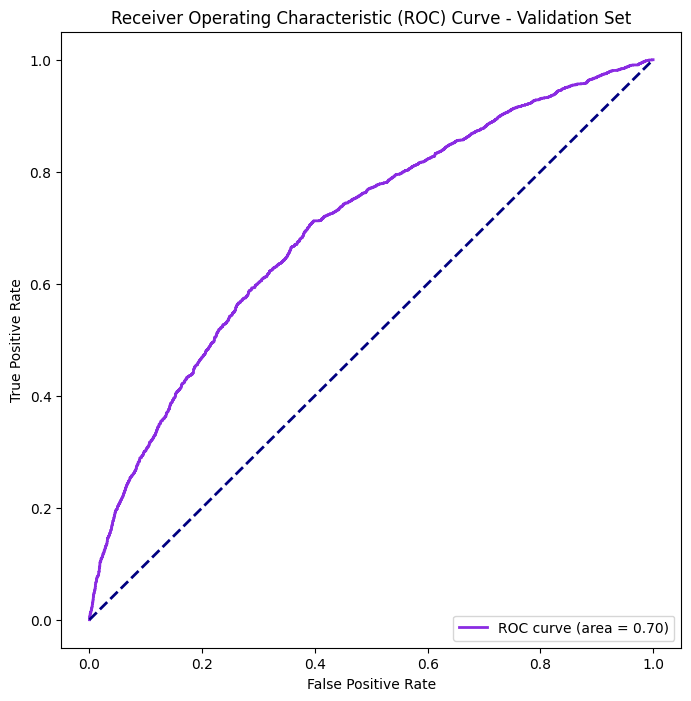

In [ ]:
knn_selected_indices = importance_knn.argsort()[-6:][::-1]
knn_selected_features = feature_names[knn_selected_indices]
print("Top 5 KNN Selected Features:", knn_selected_features)
X_train_selected_knn = X_train[knn_selected_features]
X_validation_selected_knn = X_validation[knn_selected_features]
scaler = StandardScaler()
X_train_selected_scaled_knn = scaler.fit_transform(X_train_selected_knn)
X_validation_selected_scaled_knn = scaler.transform(X_validation_selected_knn)
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_train_selected_scaled_knn, y_train)

train_predictions = svm_model.predict(X_train_selected_scaled_knn)
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, zero_division=1)
train_recall = recall_score(y_train, train_predictions, zero_division=1)
train_f1 = f1_score(y_train, train_predictions, zero_division=1)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")

validation_predictions = svm_model.predict(X_validation_selected_scaled_knn)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
validation_precision = precision_score(y_validation, validation_predictions, zero_division=1)
validation_recall = recall_score(y_validation, validation_predictions, zero_division=1)
validation_f1 = f1_score(y_validation, validation_predictions, zero_division=1)

print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Validation Precision: {validation_precision:.4f}")
print(f"Validation Recall: {validation_recall:.4f}")
print(f"Validation F1 Score: {validation_f1:.4f}")

fpr_val, tpr_val, thresholds_val = roc_curve(y_validation, svm_model.decision_function(X_validation_selected_scaled_knn))
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend(loc='lower right')
plt.show()


*sigmoid*

Top 5 KNN Selected Features: ['PRBUsageUL' 'CellName' 'maxThr_DL' 'maxUE_UL+DL' 'PRBUsageDL'
 'maxThr_UL']
Training Accuracy: 0.6271
Training Precision: 0.3232
Training Recall: 0.3214
Training F1 Score: 0.3223
Validation Accuracy: 0.6391
Validation Precision: 0.3424
Validation Recall: 0.3343
Validation F1 Score: 0.3383


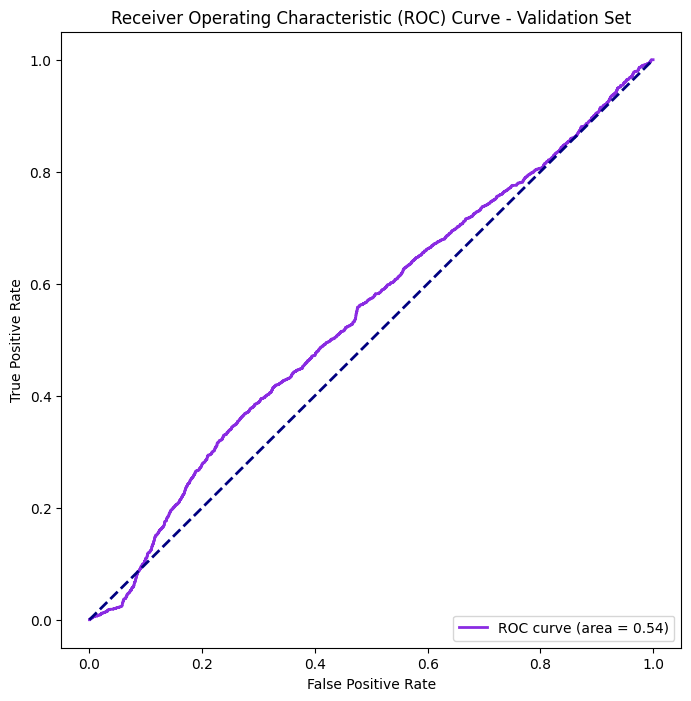

In [ ]:
knn_selected_indices = importance_knn.argsort()[-6:][::-1]
knn_selected_features = feature_names[knn_selected_indices]
print("Top 5 KNN Selected Features:", knn_selected_features)
X_train_selected_knn = X_train[knn_selected_features]
X_validation_selected_knn = X_validation[knn_selected_features]
scaler = StandardScaler()
X_train_selected_scaled_knn = scaler.fit_transform(X_train_selected_knn)
X_validation_selected_scaled_knn = scaler.transform(X_validation_selected_knn)
svm_model = SVC(kernel='sigmoid', C=1.0, random_state=42)
svm_model.fit(X_train_selected_scaled_knn, y_train)
train_predictions = svm_model.predict(X_train_selected_scaled_knn)
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")

validation_predictions = svm_model.predict(X_validation_selected_scaled_knn)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
validation_precision = precision_score(y_validation, validation_predictions)
validation_recall = recall_score(y_validation, validation_predictions)
validation_f1 = f1_score(y_validation, validation_predictions)

print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Validation Precision: {validation_precision:.4f}")
print(f"Validation Recall: {validation_recall:.4f}")
print(f"Validation F1 Score: {validation_f1:.4f}")

fpr_val, tpr_val, thresholds_val = roc_curve(y_validation, svm_model.decision_function(X_validation_selected_scaled_knn))
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend(loc='lower right')
plt.show()


***SVM + Gini in Decision Tree***

*poly*

In [ ]:
X_train_top_features_gini = X_train[top_features_gini]
X_validation_top_features_gini = X_validation[top_features_gini]
scaler = StandardScaler()
X_train_top_features_gini_scaled = scaler.fit_transform(X_train_top_features_gini)
X_validation_top_features_gini_scaled = scaler.transform(X_validation_top_features_gini)
svm_model_gini = SVC(kernel='poly', C=1.0, random_state=42)
svm_model_gini.fit(X_train_top_features_gini_scaled, y_train)

train_predictions_gini = svm_model_gini.predict(X_train_top_features_gini_scaled)
train_accuracy_gini = accuracy_score(y_train, train_predictions_gini)
train_precision_gini = precision_score(y_train, train_predictions_gini, zero_division=0)
train_recall_gini = recall_score(y_train, train_predictions_gini, zero_division=0)
train_f1_gini = f1_score(y_train, train_predictions_gini, zero_division=0)


print(f"Training Accuracy (gini): {train_accuracy_gini:.4f}")
print(f"Training Precision (gini): {train_precision_gini:.4f}")
print(f"Training Recall (gini): {train_recall_gini:.4f}")
print(f"Training F1 Score (gini): {train_f1_gini:.4f}")

validation_predictions_gini = svm_model_gini.predict(X_validation_top_features_gini_scaled)
validation_accuracy_gini = accuracy_score(y_validation, validation_predictions_gini)
validation_precision_gini = precision_score(y_validation, validation_predictions_gini)
validation_recall_gini = recall_score(y_validation, validation_predictions_gini)
validation_f1_gini = f1_score(y_validation, validation_predictions_gini)

print(f"Validation Accuracy (gini): {validation_accuracy_gini:.4f}")
print(f"Validation Precision (gini): {validation_precision_gini:.4f}")
print(f"Validation Recall (gini): {validation_recall_gini:.4f}")
print(f"Validation F1 Score (gini): {validation_f1_gini:.4f}")

fpr_gini, tpr_gini, _ = roc_curve(y_validation, svm_model_gini.decision_function(X_validation_top_features_gini_scaled))
roc_auc_gini = auc(fpr_gini, tpr_gini)

plt.figure(figsize=(8, 8))
plt.plot(fpr_gini, tpr_gini, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_gini:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM (gini)')
plt.legend(loc='lower right')
plt.show()


*rbf*

In [ ]:
X_train_top_features_gini = X_train[top_features_gini]
X_validation_top_features_gini = X_validation[top_features_gini]
scaler = StandardScaler()
X_train_top_features_gini_scaled = scaler.fit_transform(X_train_top_features_gini)
X_validation_top_features_gini_scaled = scaler.transform(X_validation_top_features_gini)
X_validation_top_features_gini_scaled_cleaned = numpy.nan_to_num(X_validation_top_features_gini_scaled)

svm_model_gini = SVC(kernel='rbf', C=0.5, gamma='auto', random_state=42)
svm_model_gini.fit(X_train_top_features_gini_scaled, y_train)

train_predictions_gini = svm_model_gini.predict(X_train_top_features_gini_scaled)
train_accuracy_gini = accuracy_score(y_train, train_predictions_gini)
train_precision_gini = precision_score(y_train, train_predictions_gini)
train_recall_gini = recall_score(y_train, train_predictions_gini)
train_f1_gini = f1_score(y_train, train_predictions_gini)

print(f"Training Accuracy (gini): {train_accuracy_gini:.4f}")
print(f"Training Precision (gini): {train_precision_gini:.4f}")
print(f"Training Recall (gini): {train_recall_gini:.4f}")
print(f"Training F1 Score (gini): {train_f1_gini:.4f}")

validation_predictions_gini = svm_model_gini.predict(X_validation_top_features_gini_scaled_cleaned)
validation_accuracy_gini = accuracy_score(y_validation, validation_predictions_gini)
validation_precision_gini = precision_score(y_validation, validation_predictions_gini)
validation_recall_gini = recall_score(y_validation, validation_predictions_gini)
validation_f1_gini = f1_score(y_validation, validation_predictions_gini)

print(f"Validation Accuracy (gini): {validation_accuracy_gini:.4f}")
print(f"Validation Precision (gini): {validation_precision_gini:.4f}")
print(f"Validation Recall (gini): {validation_recall_gini:.4f}")
print(f"Validation F1 Score (gini): {validation_f1_gini:.4f}")

fpr_gini, tpr_gini, _ = roc_curve(y_validation, svm_model_gini.decision_function(X_validation_top_features_gini_scaled_cleaned))
roc_auc_gini = auc(fpr_gini, tpr_gini)

plt.figure(figsize=(8, 8))
plt.plot(fpr_gini, tpr_gini, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_gini:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM (gini)')
plt.legend(loc='lower right')
plt.show()


*sigmoid*

Training Accuracy (gini): 0.5843
Training Precision (gini): 0.2459
Training Recall (gini): 0.2453
Training F1 Score (gini): 0.2456
Validation Accuracy (gini): 0.5906
Validation Precision (gini): 0.2577
Validation Recall (gini): 0.2572
Validation F1 Score (gini): 0.2575


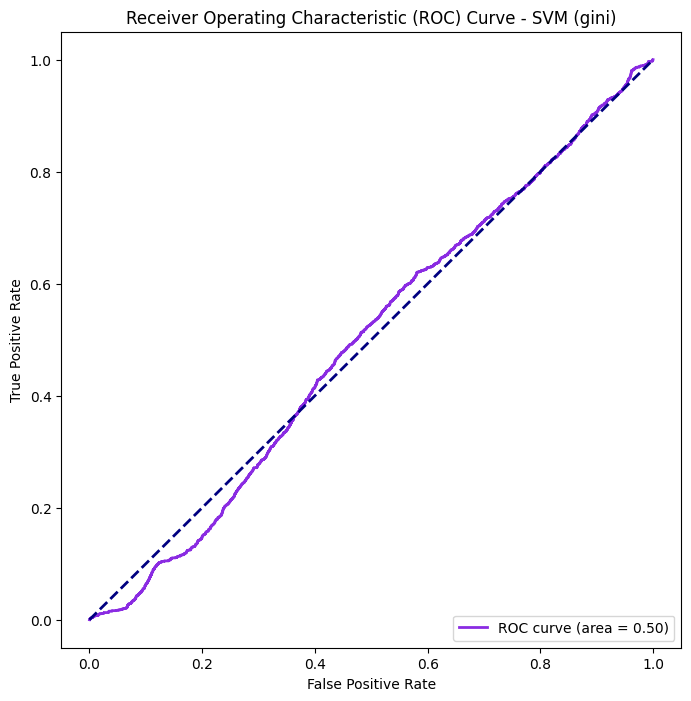

In [ ]:
X_train_top_features_gini = X_train[top_features_gini]
X_validation_top_features_gini = X_validation[top_features_gini]
scaler = StandardScaler()
X_train_top_features_gini_scaled = scaler.fit_transform(X_train_top_features_gini)
X_validation_top_features_gini_scaled = scaler.transform(X_validation_top_features_gini)
X_validation_top_features_gini_scaled_cleaned = numpy.nan_to_num(X_validation_top_features_gini_scaled)

svm_model_gini = SVC(kernel='sigmoid', C=1.0, random_state=42)
svm_model_gini.fit(X_train_top_features_gini_scaled, y_train)

train_predictions_gini = svm_model_gini.predict(X_train_top_features_gini_scaled)
train_accuracy_gini = accuracy_score(y_train, train_predictions_gini)
train_precision_gini = precision_score(y_train, train_predictions_gini)
train_recall_gini = recall_score(y_train, train_predictions_gini)
train_f1_gini = f1_score(y_train, train_predictions_gini)

print(f"Training Accuracy (gini): {train_accuracy_gini:.4f}")
print(f"Training Precision (gini): {train_precision_gini:.4f}")
print(f"Training Recall (gini): {train_recall_gini:.4f}")
print(f"Training F1 Score (gini): {train_f1_gini:.4f}")

validation_predictions_gini = svm_model_gini.predict(X_validation_top_features_gini_scaled_cleaned)
validation_accuracy_gini = accuracy_score(y_validation, validation_predictions_gini)
validation_precision_gini = precision_score(y_validation, validation_predictions_gini)
validation_recall_gini = recall_score(y_validation, validation_predictions_gini)
validation_f1_gini = f1_score(y_validation, validation_predictions_gini)

print(f"Validation Accuracy (gini): {validation_accuracy_gini:.4f}")
print(f"Validation Precision (gini): {validation_precision_gini:.4f}")
print(f"Validation Recall (gini): {validation_recall_gini:.4f}")
print(f"Validation F1 Score (gini): {validation_f1_gini:.4f}")

fpr_gini, tpr_gini, _ = roc_curve(y_validation, svm_model_gini.decision_function(X_validation_top_features_gini_scaled_cleaned))
roc_auc_gini = auc(fpr_gini, tpr_gini)

plt.figure(figsize=(8, 8))
plt.plot(fpr_gini, tpr_gini, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_gini:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM (gini)')
plt.legend(loc='lower right')
plt.show()


*linear*

Training Accuracy (gini): 0.7241
Training Precision (gini): 0.0000
Training Recall (gini): 0.0000
Training F1 Score (gini): 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Validation Accuracy (gini): 0.7240
Validation Precision (gini): 0.0000
Validation Recall (gini): 0.0000
Validation F1 Score (gini): 0.0000


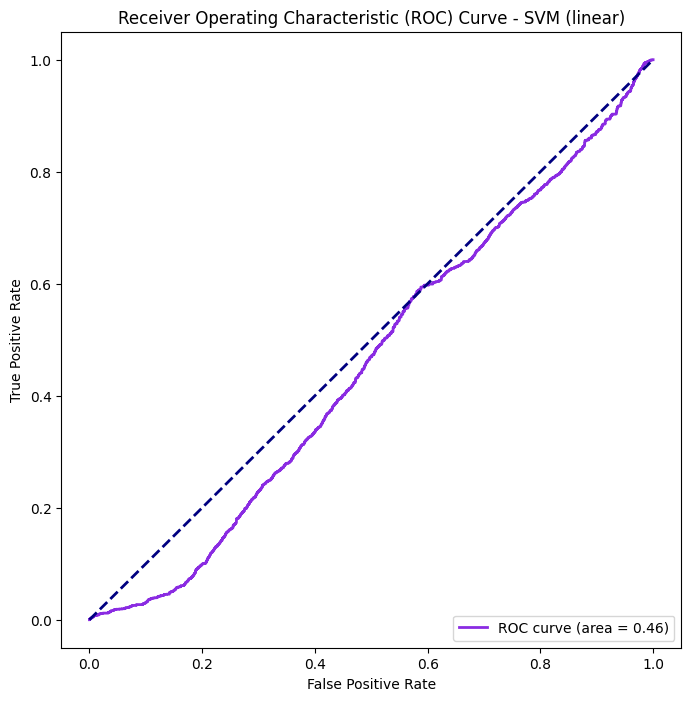

In [ ]:
X_train_top_features_gini = X_train[top_features_gini]
X_validation_top_features_gini = X_validation[top_features_gini]

scaler = StandardScaler()
X_train_top_features_gini_scaled = scaler.fit_transform(X_train_top_features_gini)
X_validation_top_features_gini_scaled = scaler.transform(X_validation_top_features_gini)

svm_model_gini = SVC(kernel='linear', C=1.0, random_state=42)
svm_model_gini.fit(X_train_top_features_gini_scaled, y_train)

train_predictions_gini = svm_model_gini.predict(X_train_top_features_gini_scaled)
train_accuracy_gini = accuracy_score(y_train, train_predictions_gini)
train_precision_gini = precision_score(y_train, train_predictions_gini, zero_division=0)
train_recall_gini = recall_score(y_train, train_predictions_gini, zero_division=0)
train_f1_gini = f1_score(y_train, train_predictions_gini, zero_division=0)


print(f"Training Accuracy (gini): {train_accuracy_gini:.4f}")
print(f"Training Precision (gini): {train_precision_gini:.4f}")
print(f"Training Recall (gini): {train_recall_gini:.4f}")
print(f"Training F1 Score (gini): {train_f1_gini:.4f}")

validation_predictions_gini = svm_model_gini.predict(X_validation_top_features_gini_scaled)
validation_accuracy_gini = accuracy_score(y_validation, validation_predictions_gini)
validation_precision_gini = precision_score(y_validation, validation_predictions_gini)
validation_recall_gini = recall_score(y_validation, validation_predictions_gini)
validation_f1_gini = f1_score(y_validation, validation_predictions_gini)

print(f"Validation Accuracy (gini): {validation_accuracy_gini:.4f}")
print(f"Validation Precision (gini): {validation_precision_gini:.4f}")
print(f"Validation Recall (gini): {validation_recall_gini:.4f}")
print(f"Validation F1 Score (gini): {validation_f1_gini:.4f}")

fpr_gini, tpr_gini, _ = roc_curve(y_validation, svm_model_gini.decision_function(X_validation_top_features_gini_scaled))
roc_auc_gini = auc(fpr_gini, tpr_gini)

plt.figure(figsize=(8, 8))
plt.plot(fpr_gini, tpr_gini, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_gini:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM (linear)')
plt.legend(loc='lower right')
plt.show()


***SVM + Sequrntial (F , B ) Feature Selection***

Training Accuracy (selected features): 0.7529
Training Precision (selected features): 0.7779
Training Recall (selected features): 0.1361
Training F1 Score (selected features): 0.2317
Validation Accuracy (selected features): 0.7590
Validation Precision (selected features): 0.8278
Validation Recall (selected features): 0.1503
Validation F1 Score (selected features): 0.2544


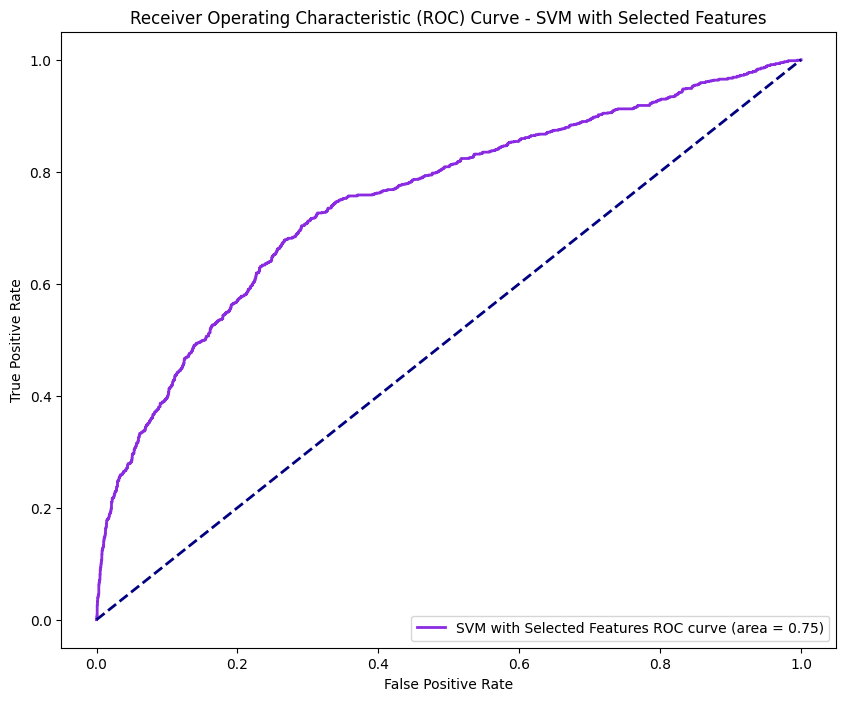

In [ ]:
selected_features = feature_names[sfs_forward.get_support()]
X_train_selected = X_train[selected_features]
X_validation_selected = X_validation[selected_features]
scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_validation_selected_scaled = scaler.transform(X_validation_selected)


svm_model_selected = SVC(kernel='rbf', random_state=42)
svm_model_selected.fit(X_train_selected_scaled, y_train)
train_predictions_selected = svm_model_selected.predict(X_train_selected_scaled)
train_accuracy_selected = accuracy_score(y_train, train_predictions_selected)
train_precision_selected = precision_score(y_train, train_predictions_selected)
train_recall_selected = recall_score(y_train, train_predictions_selected)
train_f1_selected = f1_score(y_train, train_predictions_selected)

print(f"Training Accuracy (selected features): {train_accuracy_selected:.4f}")
print(f"Training Precision (selected features): {train_precision_selected:.4f}")
print(f"Training Recall (selected features): {train_recall_selected:.4f}")
print(f"Training F1 Score (selected features): {train_f1_selected:.4f}")

validation_predictions_selected = svm_model_selected.predict(X_validation_selected_scaled)
validation_accuracy_selected = accuracy_score(y_validation, validation_predictions_selected)
validation_precision_selected = precision_score(y_validation, validation_predictions_selected)
validation_recall_selected = recall_score(y_validation, validation_predictions_selected)
validation_f1_selected = f1_score(y_validation, validation_predictions_selected)

print(f"Validation Accuracy (selected features): {validation_accuracy_selected:.4f}")
print(f"Validation Precision (selected features): {validation_precision_selected:.4f}")
print(f"Validation Recall (selected features): {validation_recall_selected:.4f}")
print(f"Validation F1 Score (selected features): {validation_f1_selected:.4f}")

fpr, tpr, _ = roc_curve(y_validation, svm_model_selected.decision_function(X_validation_selected_scaled))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM with Selected Features')
plt.legend(loc='lower right')
plt.show()


***SVM + Kendall Test***

Training Accuracy (selected features - Kendall): 0.7253
Training Precision (selected features - Kendall): 0.8491
Training Recall (selected features - Kendall): 0.0055
Training F1 Score (selected features - Kendall): 0.0110
Validation Accuracy (selected features - Kendall): 0.7242
Validation Precision (selected features - Kendall): 0.5556
Validation Recall (selected features - Kendall): 0.0025
Validation F1 Score (selected features - Kendall): 0.0049


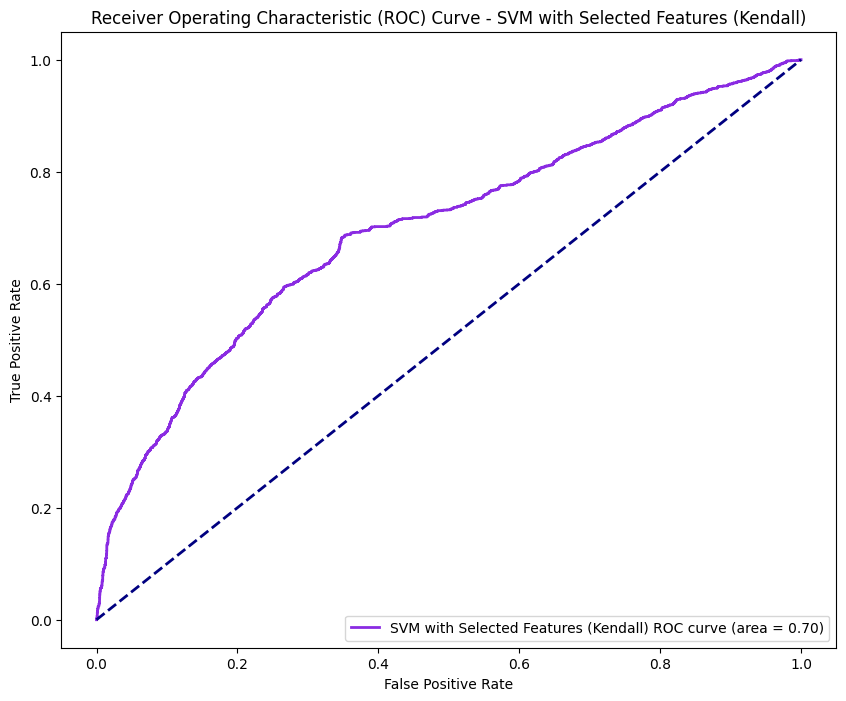

In [ ]:
X_train_selected_kendall = X_train[selected_features_kendall]
X_validation_selected_kendall = X_validation[selected_features_kendall]

svm_model_selected_kendall = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model_selected_kendall.fit(X_train_selected_kendall, y_train)

train_predictions_selected_kendall = svm_model_selected_kendall.predict(X_train_selected_kendall)
train_accuracy_selected_kendall = accuracy_score(y_train, train_predictions_selected_kendall)
train_precision_selected_kendall = precision_score(y_train, train_predictions_selected_kendall, zero_division=1)
train_recall_selected_kendall = recall_score(y_train, train_predictions_selected_kendall, zero_division=1)
train_f1_selected_kendall = f1_score(y_train, train_predictions_selected_kendall, zero_division=1)

print(f"Training Accuracy (selected features - Kendall): {train_accuracy_selected_kendall:.4f}")
print(f"Training Precision (selected features - Kendall): {train_precision_selected_kendall:.4f}")
print(f"Training Recall (selected features - Kendall): {train_recall_selected_kendall:.4f}")
print(f"Training F1 Score (selected features - Kendall): {train_f1_selected_kendall:.4f}")

validation_predictions_selected_kendall = svm_model_selected_kendall.predict(X_validation_selected_kendall)
validation_accuracy_selected_kendall = accuracy_score(y_validation, validation_predictions_selected_kendall)
validation_precision_selected_kendall = precision_score(y_validation, validation_predictions_selected_kendall, zero_division=1)
validation_recall_selected_kendall = recall_score(y_validation, validation_predictions_selected_kendall, zero_division=1)
validation_f1_selected_kendall = f1_score(y_validation, validation_predictions_selected_kendall, zero_division=1)

print(f"Validation Accuracy (selected features - Kendall): {validation_accuracy_selected_kendall:.4f}")
print(f"Validation Precision (selected features - Kendall): {validation_precision_selected_kendall:.4f}")
print(f"Validation Recall (selected features - Kendall): {validation_recall_selected_kendall:.4f}")
print(f"Validation F1 Score (selected features - Kendall): {validation_f1_selected_kendall:.4f}")

fpr_kendall, tpr_kendall, _ = roc_curve(y_validation, svm_model_selected_kendall.decision_function(X_validation_selected_kendall))
roc_auc_kendall = auc(fpr_kendall, tpr_kendall)

plt.figure(figsize=(8, 8))
plt.plot(fpr_kendall, tpr_kendall, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_kendall:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM with Selected Features (Kendall)')
plt.legend(loc='lower right')
plt.show()


***SVM + Hist Gradient Bossting Feaure Selection***

*rbf*

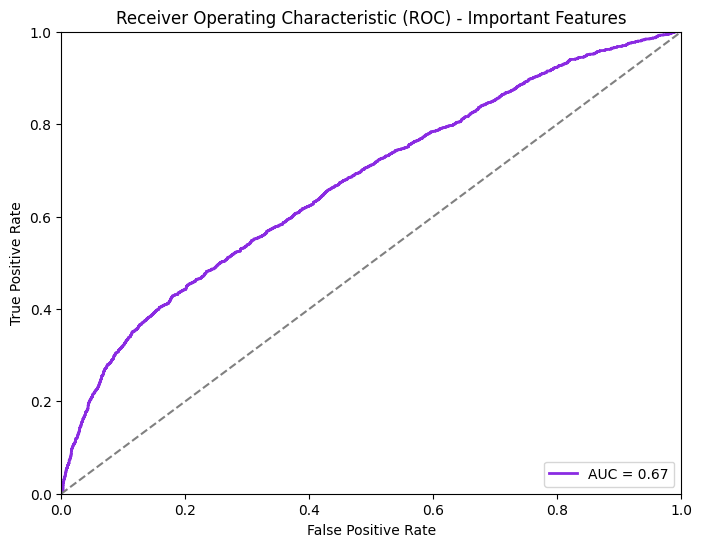

Accuracy with SVM (Important Features): 72.40%
Precision with SVM (Important Features): 0.0000
Recall with SVM (Important Features): 0.0000
F1 Score with SVM (Important Features): 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
important_features = X.columns[sorted_idx_gbc][-6:]

X_train_important = X_train[important_features]
X_validation_important = X_validation[important_features]

svm_model_important = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_model_important.fit(X_train_important, y_train)

y_pred_proba_important = svm_model_important.predict_proba(X_validation_important)[:, 1]

fpr_important, tpr_important, thresholds_important = roc_curve(y_validation, y_pred_proba_important)
roc_auc_important = auc(fpr_important, tpr_important)

plt.figure(figsize=(8, 6))
plt.plot(fpr_important, tpr_important, color='blueviolet', lw=2, label=f'AUC = {roc_auc_important:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Important Features')
plt.legend(loc='lower right')
plt.show()

y_pred_svm_important = svm_model_important.predict(X_validation_important)

accuracy_svm_important = accuracy_score(y_validation, y_pred_svm_important)
precision_svm_important = precision_score(y_validation, y_pred_svm_important)
recall_svm_important = recall_score(y_validation, y_pred_svm_important)
f1_svm_important = f1_score(y_validation, y_pred_svm_important)

print(f'Accuracy with SVM (Important Features): {accuracy_svm_important:.2%}')
print(f'Precision with SVM (Important Features): {precision_svm_important:.4f}')
print(f'Recall with SVM (Important Features): {recall_svm_important:.4f}')
print(f'F1 Score with SVM (Important Features): {f1_svm_important:.4f}')


###**3.Decision Tree Classifier**

*gini*

Training Accuracy: 0.9168
Validation Accuracy: 0.9198
Confusion Matrix:
[[5162  182]
 [ 410 1627]]
Precision: 0.8994
Recall: 0.7987
F1-Score: 0.8461
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5344
           1       0.90      0.80      0.85      2037

    accuracy                           0.92      7381
   macro avg       0.91      0.88      0.90      7381
weighted avg       0.92      0.92      0.92      7381



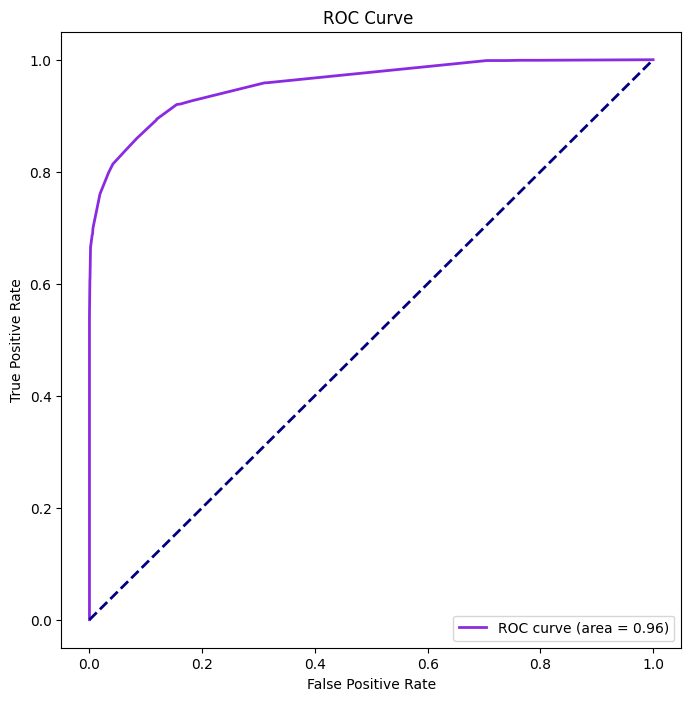

In [ ]:
X_train_selected_tree = X_train[top_features_gini]
X_validation_selected_tree = X_validation[top_features_gini]

tree_model = DecisionTreeClassifier(criterion='gini', max_features='sqrt', max_depth=16, ccp_alpha=0.001)
tree_model.fit(X_train_selected_tree, y_train)

train_predictions = tree_model.predict(X_train_selected_tree)
validation_predictions = tree_model.predict(X_validation_selected_tree)

train_accuracy = accuracy_score(y_train, train_predictions)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

conf_matrix = confusion_matrix(y_validation, validation_predictions)
print("Confusion Matrix:")
print(conf_matrix)

precision = precision_score(y_validation, validation_predictions)
recall = recall_score(y_validation, validation_predictions)
f1 = f1_score(y_validation, validation_predictions)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

class_report = classification_report(y_validation, validation_predictions)
print("Classification Report:")
print(class_report)

fpr_val, tpr_val, thresholds_val = roc_curve(y_validation, tree_model.predict_proba(X_validation_selected_tree)[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.legend(loc='lower right')
plt.show()


Training Accuracy: 0.9119
Validation Accuracy: 0.9175
Confusion Matrix:
[[5126  218]
 [ 391 1646]]
Precision: 0.8830
Recall: 0.8081
F1-Score: 0.8439
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5344
           1       0.88      0.81      0.84      2037

    accuracy                           0.92      7381
   macro avg       0.91      0.88      0.89      7381
weighted avg       0.92      0.92      0.92      7381



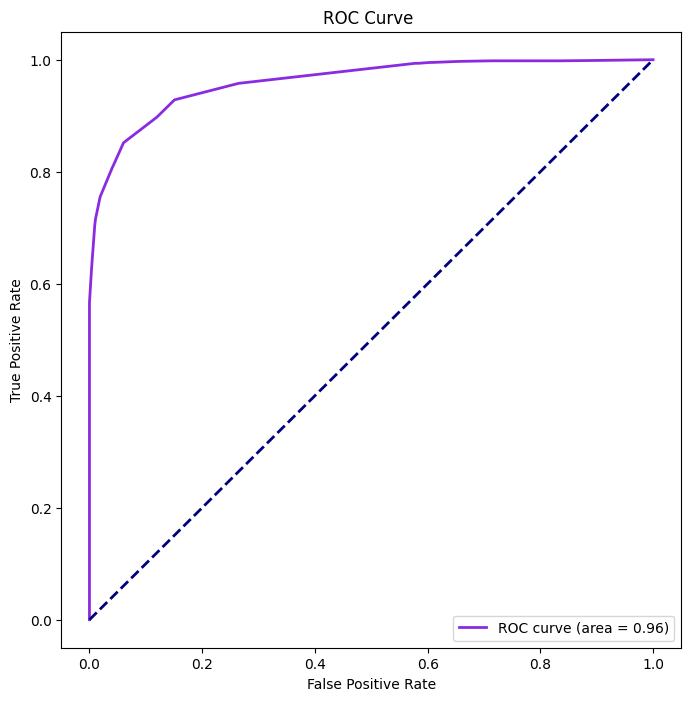

In [ ]:
X_train_selected_tree = X_train[top_features_gini]
X_validation_selected_tree = X_validation[top_features_gini]

tree_model = DecisionTreeClassifier(criterion='gini', max_features='log2', max_depth=324, ccp_alpha=0.001)
tree_model.fit(X_train_selected_tree, y_train)

train_predictions = tree_model.predict(X_train_selected_tree)
validation_predictions = tree_model.predict(X_validation_selected_tree)

train_accuracy = accuracy_score(y_train, train_predictions)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

conf_matrix = confusion_matrix(y_validation, validation_predictions)
print("Confusion Matrix:")
print(conf_matrix)

precision = precision_score(y_validation, validation_predictions)
recall = recall_score(y_validation, validation_predictions)
f1 = f1_score(y_validation, validation_predictions)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

class_report = classification_report(y_validation, validation_predictions)
print("Classification Report:")
print(class_report)

fpr_val, tpr_val, thresholds_val = roc_curve(y_validation, tree_model.predict_proba(X_validation_selected_tree)[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.legend(loc='lower right')
plt.show()


*log_loss*

Training Accuracy: 0.9473
Validation Accuracy: 0.9495
Confusion Matrix:
[[5248   96]
 [ 277 1760]]
Precision: 0.9482758620689655
Recall: 0.8640157093765342
F1-Score: 0.9041870023118418
Validation ROC Curve (AUC = 0.98):


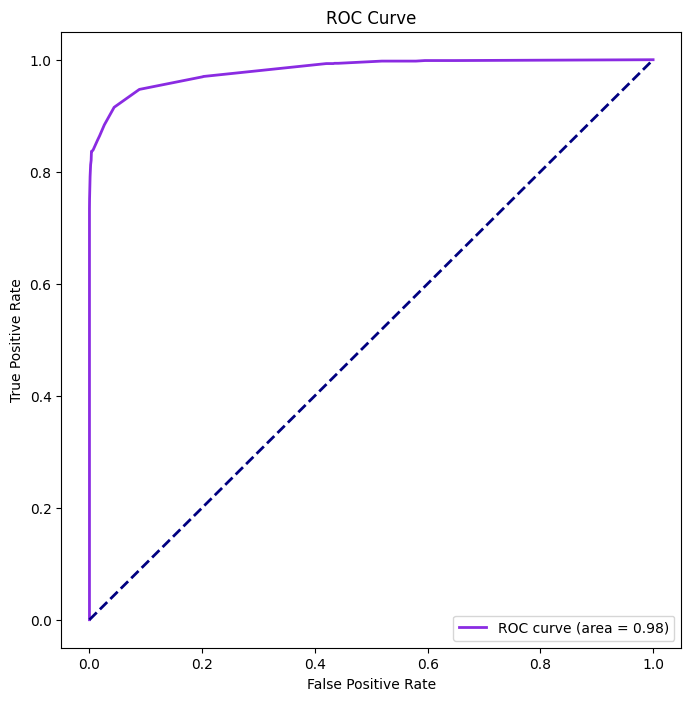

In [ ]:
X_train_selected_tree = X_train[top_features_gini]
X_validation_selected_tree = X_validation[top_features_gini]

tree_model = DecisionTreeClassifier(criterion='log_loss', max_features='sqrt', max_depth=32, ccp_alpha=0.001)
tree_model.fit(X_train_selected_tree, y_train)

train_predictions = tree_model.predict(X_train_selected_tree)
validation_predictions = tree_model.predict(X_validation_selected_tree)

train_accuracy = accuracy_score(y_train, train_predictions)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

fpr_val, tpr_val, thresholds_val = roc_curve(y_validation, tree_model.predict_proba(X_validation_selected_tree)[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

print("Confusion Matrix:")
print(confusion_matrix(y_validation, validation_predictions))

print("Precision:", precision_score(y_validation, validation_predictions))
print("Recall:", recall_score(y_validation, validation_predictions))
print("F1-Score:", f1_score(y_validation, validation_predictions))

print(f"Validation ROC Curve (AUC = {roc_auc_val:.2f}):")
plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


  *log_loss + log2*

Training Accuracy: 0.9333
Training Precision: 0.9221
Training Recall: 0.8284
Training F1 Score: 0.8727
Validation Accuracy: 0.9332
Validation Precision: 0.9191
Validation Recall: 0.8311
Validation F1 Score: 0.8729


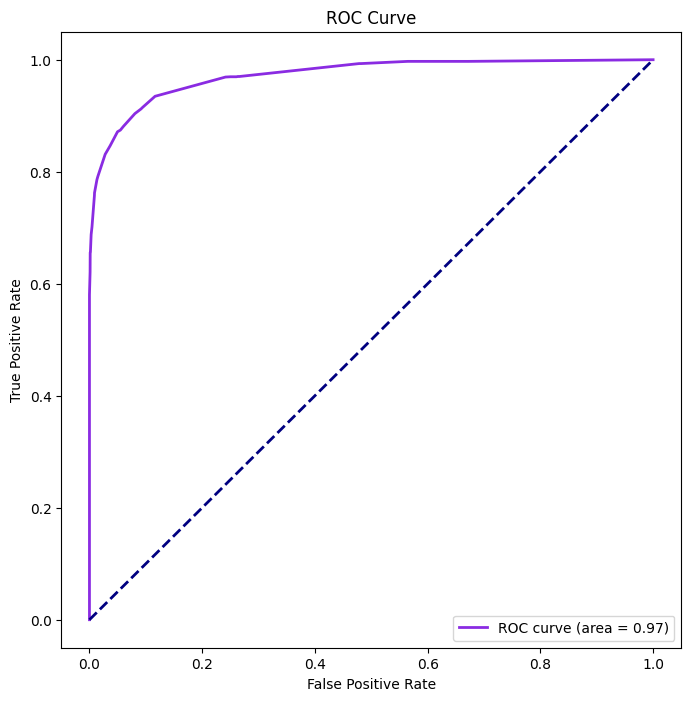

In [ ]:
X_train_selected_tree = X_train[top_features_gini]
X_validation_selected_tree = X_validation[top_features_gini]

tree_model = DecisionTreeClassifier(criterion='log_loss', max_features='log2', max_depth=32, ccp_alpha=0.001)
tree_model.fit(X_train_selected_tree, y_train)

train_predictions = tree_model.predict(X_train_selected_tree)
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")

validation_predictions = tree_model.predict(X_validation_selected_tree)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
validation_precision = precision_score(y_validation, validation_predictions)
validation_recall = recall_score(y_validation, validation_predictions)
validation_f1 = f1_score(y_validation, validation_predictions)

print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Validation Precision: {validation_precision:.4f}")
print(f"Validation Recall: {validation_recall:.4f}")
print(f"Validation F1 Score: {validation_f1:.4f}")

fpr_val, tpr_val, thresholds_val = roc_curve(y_validation, tree_model.predict_proba(X_validation_selected_tree)[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

*entropy*

Training Accuracy: 0.9427
Validation Accuracy: 0.9435
Confusion Matrix:
[[5251   93]
 [ 324 1713]]
Precision: 0.9485049833887044
Recall: 0.8409425625920471
F1-Score: 0.8914910226385636
Validation ROC Curve (AUC = 0.97):


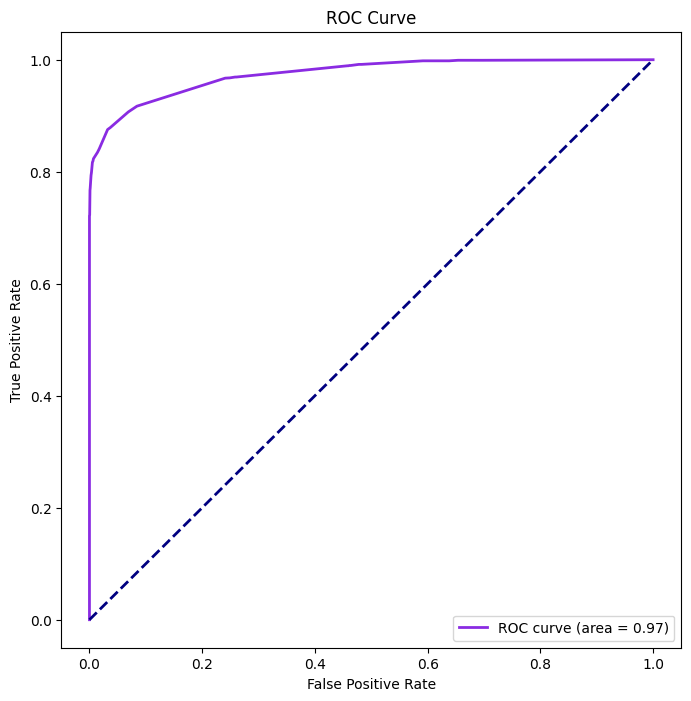

In [ ]:
X_train_selected_tree = X_train[top_features_gini]
X_validation_selected_tree = X_validation[top_features_gini]

tree_model = DecisionTreeClassifier(criterion='entropy', max_features='sqrt', max_depth=32, ccp_alpha=0.001)
tree_model.fit(X_train_selected_tree, y_train)

train_predictions = tree_model.predict(X_train_selected_tree)
validation_predictions = tree_model.predict(X_validation_selected_tree)

train_accuracy = accuracy_score(y_train, train_predictions)
validation_accuracy = accuracy_score(y_validation, validation_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

fpr_val, tpr_val, thresholds_val = roc_curve(y_validation, tree_model.predict_proba(X_validation_selected_tree)[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

print("Confusion Matrix:")
print(confusion_matrix(y_validation, validation_predictions))

print("Precision:", precision_score(y_validation, validation_predictions))
print("Recall:", recall_score(y_validation, validation_predictions))
print("F1-Score:", f1_score(y_validation, validation_predictions))

print(f"Validation ROC Curve (AUC = {roc_auc_val:.2f}):")
plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


###***KNeightbor Classifier***

Training Accuracy (KNN): 0.8118
Validation Accuracy (KNN): 0.7327
Confusion Matrix:
[[4704  640]
 [1333  704]]
Precision: 0.5238095238095238
Recall: 0.34560628375061364
F1-Score: 0.41644483880508726
Validation ROC Curve (AUC = 0.69):


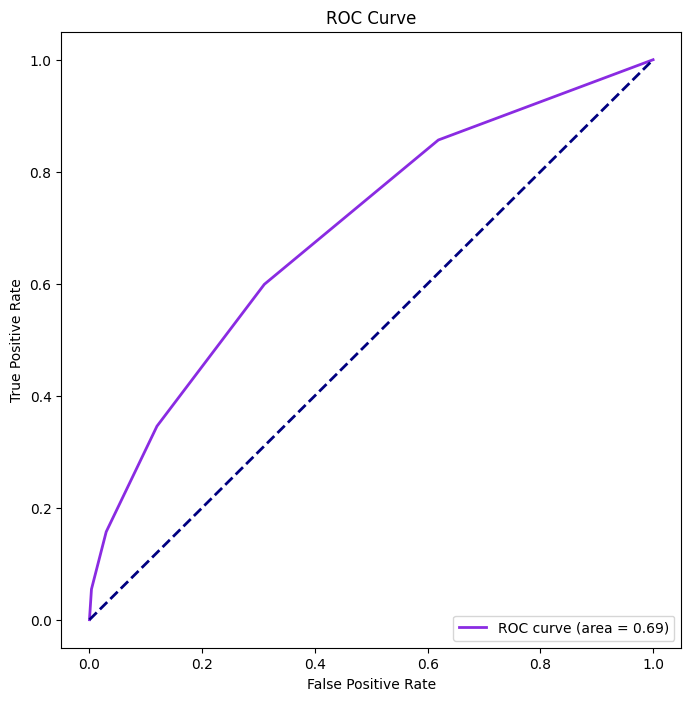

In [8]:
sorted_indices = importance_knn.argsort()[::-1]
top_features_knn = feature_names[sorted_indices][:6]

X_train_selected_knn = X_train[top_features_knn]
X_validation_selected_knn = X_validation[top_features_knn]

model_knn = KNeighborsClassifier(weights='uniform', algorithm='kd_tree')
model_knn.fit(X_train_selected_knn, y_train)

train_predictions_knn = model_knn.predict(X_train_selected_knn)
validation_predictions_knn = model_knn.predict(X_validation_selected_knn)

train_accuracy_knn = accuracy_score(y_train, train_predictions_knn)
validation_accuracy_knn = accuracy_score(y_validation, validation_predictions_knn)
print(f"Training Accuracy (KNN): {train_accuracy_knn:.4f}")
print(f"Validation Accuracy (KNN): {validation_accuracy_knn:.4f}")

fpr, tpr, thresholds = roc_curve(y_validation, model_knn.predict_proba(X_validation_selected_knn)[:, 1])
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:")
print(confusion_matrix(y_validation, validation_predictions_knn))

print("Precision:", precision_score(y_validation, validation_predictions_knn))
print("Recall:", recall_score(y_validation, validation_predictions_knn))
print("F1-Score:", f1_score(y_validation, validation_predictions_knn))

print(f"Validation ROC Curve (AUC = {roc_auc:.2f}):")
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Training Accuracy (KNN): 0.8118
Training Precision (KNN): 0.7321
Training Recall (KNN): 0.5016
Training F1 Score (KNN): 0.5953
Validation Accuracy (KNN): 0.7327
Validation Precision (KNN): 0.5238
Validation Recall (KNN): 0.3456
Validation F1 Score (KNN): 0.4164


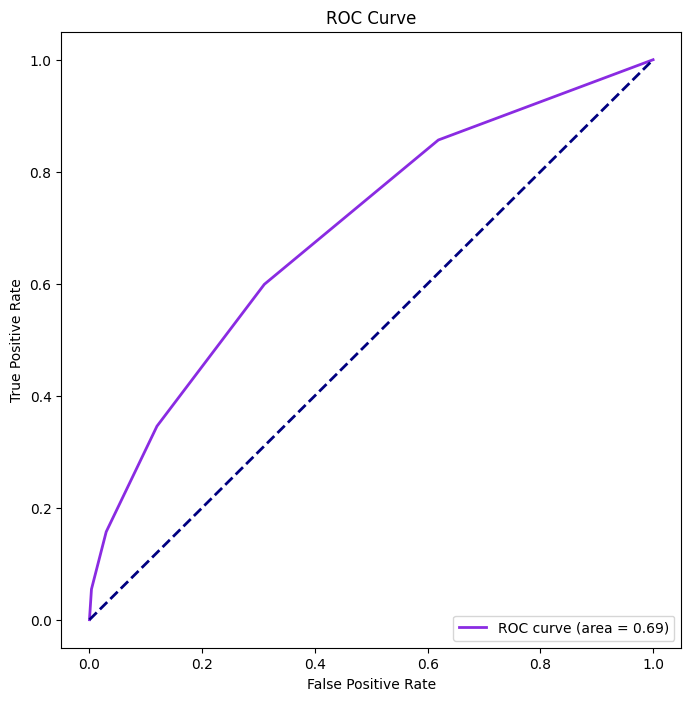

In [9]:
sorted_indices = importance_knn.argsort()[::-1]
top_features_knn = feature_names[sorted_indices][:6]

X_train_selected_knn = X_train[top_features_knn]
X_validation_selected_knn = X_validation[top_features_knn]

model_knn = KNeighborsClassifier(weights='uniform', algorithm='ball_tree', leaf_size=160)
model_knn.fit(X_train_selected_knn, y_train)

train_predictions_knn = model_knn.predict(X_train_selected_knn)
train_accuracy_knn = accuracy_score(y_train, train_predictions_knn)
train_precision_knn = precision_score(y_train, train_predictions_knn)
train_recall_knn = recall_score(y_train, train_predictions_knn)
train_f1_knn = f1_score(y_train, train_predictions_knn)

print(f"Training Accuracy (KNN): {train_accuracy_knn:.4f}")
print(f"Training Precision (KNN): {train_precision_knn:.4f}")
print(f"Training Recall (KNN): {train_recall_knn:.4f}")
print(f"Training F1 Score (KNN): {train_f1_knn:.4f}")

validation_predictions_knn = model_knn.predict(X_validation_selected_knn)
validation_accuracy_knn = accuracy_score(y_validation, validation_predictions_knn)
validation_precision_knn = precision_score(y_validation, validation_predictions_knn)
validation_recall_knn = recall_score(y_validation, validation_predictions_knn)
validation_f1_knn = f1_score(y_validation, validation_predictions_knn)

print(f"Validation Accuracy (KNN): {validation_accuracy_knn:.4f}")
print(f"Validation Precision (KNN): {validation_precision_knn:.4f}")
print(f"Validation Recall (KNN): {validation_recall_knn:.4f}")
print(f"Validation F1 Score (KNN): {validation_f1_knn:.4f}")

fpr, tpr, thresholds = roc_curve(y_validation, model_knn.predict_proba(X_validation_selected_knn)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Training Accuracy (KNN): 0.8091
Validation Accuracy (KNN): 0.7456
Confusion Matrix:
[[5007  337]
 [1541  496]]
Precision: 0.5954
Recall: 0.2435
F1-Score: 0.3456


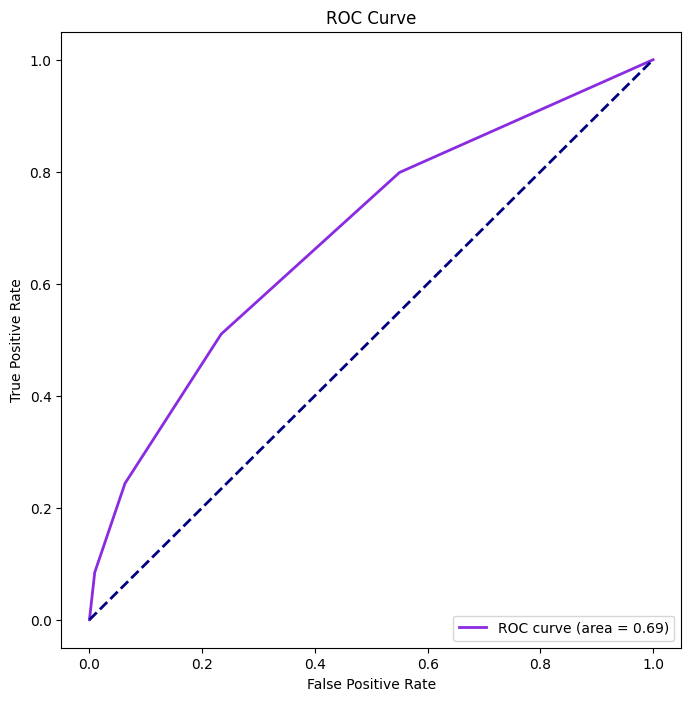

In [10]:
sorted_indices = importance_knn.argsort()[::-1]
top_features_knn = feature_names[sorted_indices][:6]

X_train_selected_knn = X_train[top_features_knn]
X_validation_selected_knn = X_validation[top_features_knn]

model_knn = KNeighborsClassifier(n_neighbors=4, weights='uniform', algorithm='brute', leaf_size=160)
model_knn.fit(X_train_selected_knn, y_train)

train_predictions_knn = model_knn.predict(X_train_selected_knn)
validation_predictions_knn = model_knn.predict(X_validation_selected_knn)

train_accuracy_knn = accuracy_score(y_train, train_predictions_knn)
validation_accuracy_knn = accuracy_score(y_validation, validation_predictions_knn)
print(f"Training Accuracy (KNN): {train_accuracy_knn:.4f}")
print(f"Validation Accuracy (KNN): {validation_accuracy_knn:.4f}")

conf_matrix = confusion_matrix(y_validation, validation_predictions_knn)
print("Confusion Matrix:")
print(conf_matrix)

precision = precision_score(y_validation, validation_predictions_knn)
recall = recall_score(y_validation, validation_predictions_knn)
f1 = f1_score(y_validation, validation_predictions_knn)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

fpr, tpr, thresholds = roc_curve(y_validation, model_knn.predict_proba(X_validation_selected_knn)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


###***Random Forest Classifier***

Index(['meanUE_UL', 'PRBUsageUL', 'meanUE_DL', 'PRBUsageDL'], dtype='object')
Cross-Validation Scores: [0.83803681 0.83670964 0.84100675 0.84162063 0.86003683]
Mean CV Accuracy: 0.8435
Standard Deviation of CV Accuracy: 0.0085
Validation Accuracy (Random Forest): 0.9531
Validation Precision (Random Forest): 0.9769
Validation Recall (Random Forest): 0.8503
Validation F1 Score (Random Forest): 0.9092


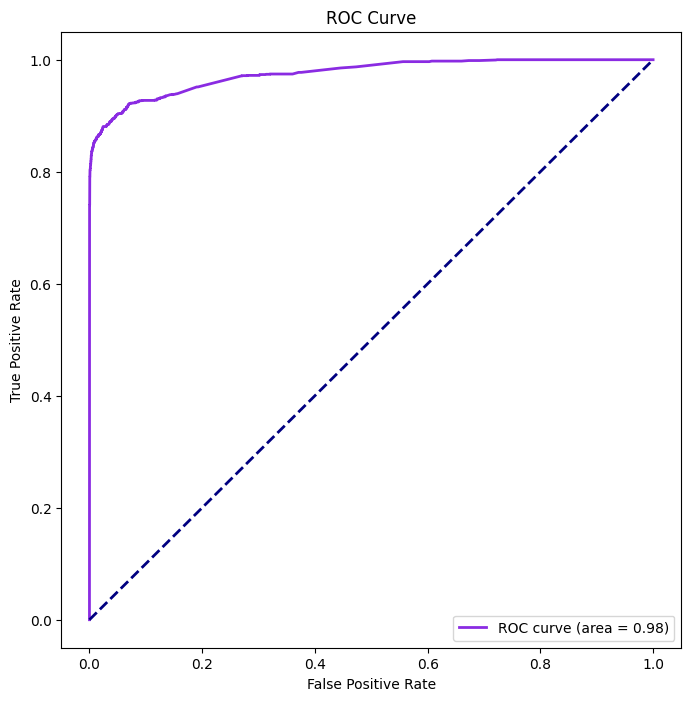

In [63]:
from sklearn.model_selection import GridSearchCV

top_features_rf = forest_importances.nlargest(4).index
X_train_selected_rf = X_train[top_features_rf]
X_validation_selected_rf = X_validation[top_features_rf]
print(top_features_rf)

rf_model = RandomForestClassifier(criterion="log_loss", max_features='log2',min_samples_leaf = 32, bootstrap = False,ccp_alpha=0.001)

cv_scores = cross_val_score(rf_model, X_train_selected_rf, y_train, cv=5, scoring='recall')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {numpy.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV Accuracy: {numpy.std(cv_scores):.4f}")

rf_model.fit(X_train_selected_rf, y_train)

validation_predictions_rf = rf_model.predict(X_validation_selected_rf)

validation_accuracy_rf = accuracy_score(y_validation, validation_predictions_rf)
validation_precision_rf = precision_score(y_validation, validation_predictions_rf)
validation_recall_rf = recall_score(y_validation, validation_predictions_rf)
validation_f1_rf = f1_score(y_validation, validation_predictions_rf)

print(f"Validation Accuracy (Random Forest): {validation_accuracy_rf:.4f}")
print(f"Validation Precision (Random Forest): {validation_precision_rf:.4f}")
print(f"Validation Recall (Random Forest): {validation_recall_rf:.4f}")
print(f"Validation F1 Score (Random Forest): {validation_f1_rf:.4f}")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_validation, rf_model.predict_proba(X_validation_selected_rf)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()


Index(['meanUE_UL', 'PRBUsageUL', 'meanUE_DL', 'PRBUsageDL'], dtype='object')
Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 'log2', 'min_samples_leaf': 2}
Cross-Validation Scores: [0.8797546  0.89502762 0.89441375 0.90116636 0.9048496 ]
Mean CV Accuracy: 0.8950
Standard Deviation of CV Accuracy: 0.0086
Validation Accuracy (Random Forest): 0.9706
Validation Precision (Random Forest): 0.9872
Validation Recall (Random Forest): 0.9053
Validation F1 Score (Random Forest): 0.9444


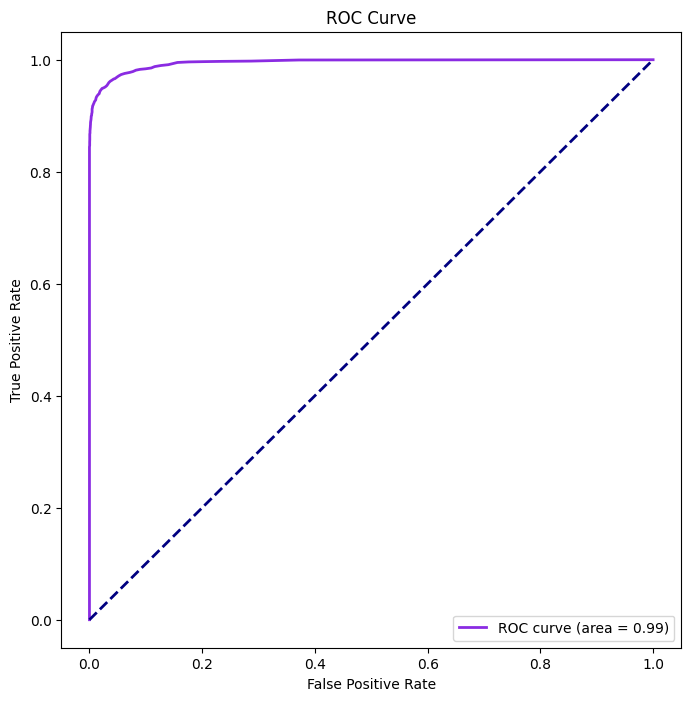

In [60]:
from sklearn.model_selection import GridSearchCV

top_features_rf = forest_importances.nlargest(4).index
X_train_selected_rf = X_train[top_features_rf]
X_validation_selected_rf = X_validation[top_features_rf]
print(top_features_rf)

param_grid = {
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth' : [2,4,8,16,32],
    'max_features': [ 'sqrt', 'log2'],
    'min_samples_leaf': [2,4,8,16,32],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='recall', cv=5)
grid_search.fit(X_train_selected_rf, y_train)
print("Best Parameters:", grid_search.best_params_)
cv_scores = cross_val_score(rf_model, X_train_selected_rf, y_train, cv=5, scoring='recall')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {numpy.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV Accuracy: {numpy.std(cv_scores):.4f}")

rf_model.fit(X_train_selected_rf, y_train)

validation_predictions_rf = rf_model.predict(X_validation_selected_rf)

validation_accuracy_rf = accuracy_score(y_validation, validation_predictions_rf)
validation_precision_rf = precision_score(y_validation, validation_predictions_rf)
validation_recall_rf = recall_score(y_validation, validation_predictions_rf)
validation_f1_rf = f1_score(y_validation, validation_predictions_rf)

print(f"Validation Accuracy (Random Forest): {validation_accuracy_rf:.4f}")
print(f"Validation Precision (Random Forest): {validation_precision_rf:.4f}")
print(f"Validation Recall (Random Forest): {validation_recall_rf:.4f}")
print(f"Validation F1 Score (Random Forest): {validation_f1_rf:.4f}")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_validation, rf_model.predict_proba(X_validation_selected_rf)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()


Index(['meanUE_UL', 'PRBUsageUL', 'meanUE_DL', 'PRBUsageDL'], dtype='object')
Cross-Validation Scores: [0.88527607 0.89502762 0.8956415  0.89625537 0.90423573]
Mean CV Accuracy: 0.8953
Standard Deviation of CV Accuracy: 0.0060
Validation Accuracy (Random Forest): 0.9715
Validation Precision (Random Forest): 0.9882
Validation Recall (Random Forest): 0.9077
Validation F1 Score (Random Forest): 0.9463


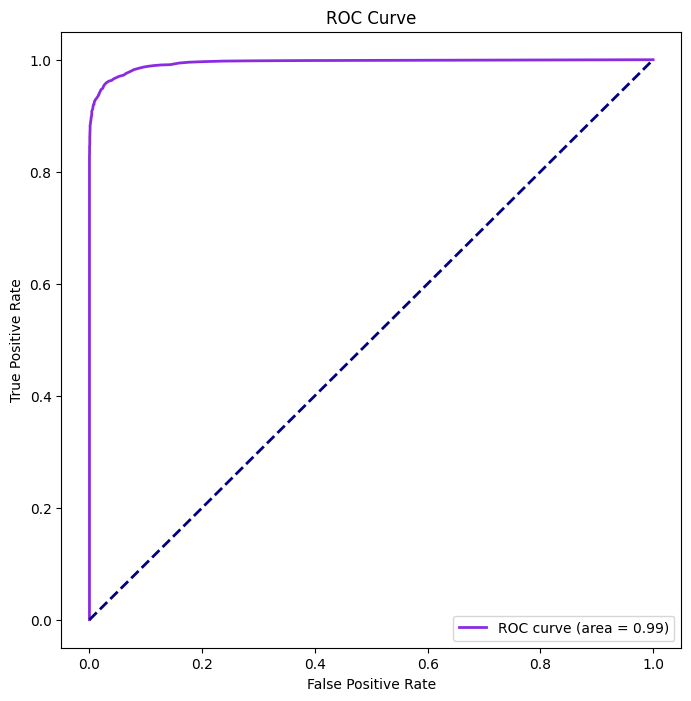

In [25]:
top_features_rf = forest_importances.nlargest(4).index
X_train_selected_rf = X_train[top_features_rf]
X_validation_selected_rf = X_validation[top_features_rf]
print(top_features_rf)

from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier()

cv_scores = cross_val_score(rf_model, X_train_selected_rf, y_train, cv=5, scoring='recall')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {numpy.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV Accuracy: {numpy.std(cv_scores):.4f}")

rf_model.fit(X_train_selected_rf, y_train)

validation_predictions_rf = rf_model.predict(X_validation_selected_rf)

validation_accuracy_rf = accuracy_score(y_validation, validation_predictions_rf)
validation_precision_rf = precision_score(y_validation, validation_predictions_rf)
validation_recall_rf = recall_score(y_validation, validation_predictions_rf)
validation_f1_rf = f1_score(y_validation, validation_predictions_rf)

print(f"Validation Accuracy (Random Forest): {validation_accuracy_rf:.4f}")
print(f"Validation Precision (Random Forest): {validation_precision_rf:.4f}")
print(f"Validation Recall (Random Forest): {validation_recall_rf:.4f}")
print(f"Validation F1 Score (Random Forest): {validation_f1_rf:.4f}")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_validation, rf_model.predict_proba(X_validation_selected_rf)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()


### ***Gradient Boosting Classfier***

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.


Training Accuracy (HistGradientBoosting): 0.8073
Training Precision (HistGradientBoosting): 0.8370
Training Recall (HistGradientBoosting): 0.3744
Training F1 Score (HistGradientBoosting): 0.5174
Validation Accuracy (HistGradientBoosting): 0.7663
Validation Precision (HistGradientBoosting): 0.6853
Validation Recall (HistGradientBoosting): 0.2833
Validation F1 Score (HistGradientBoosting): 0.4008


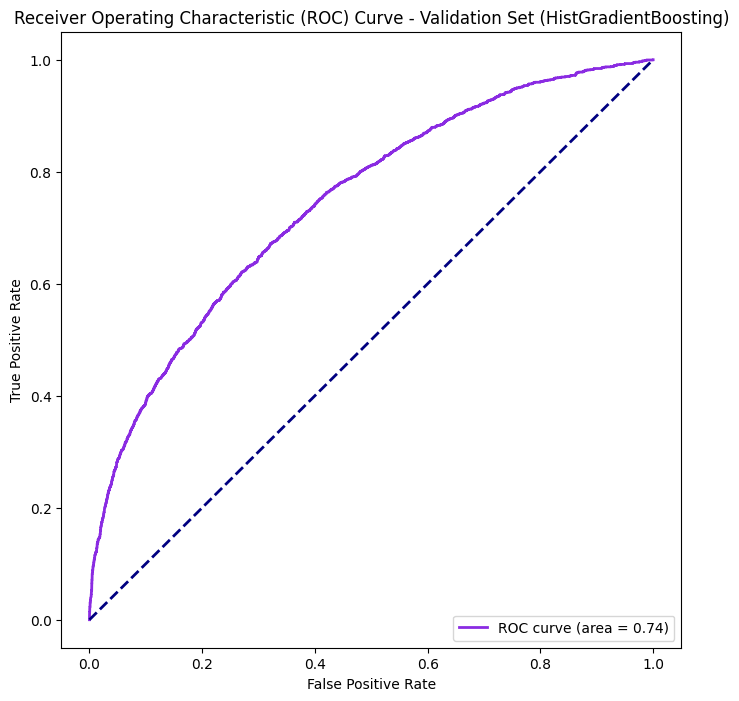

In [68]:
selected_features_gb = X.columns[sorted_idx_gbc[:6]]
X_train_selected_gb = X_train[selected_features_gb]
X_validation_selected_gb = X_validation[selected_features_gb]
gb_model = HistGradientBoostingClassifier(loss='binary_crossentropy', max_leaf_nodes=100, random_state=42, l2_regularization=2.0)
gb_model.fit(X_train_selected_gb, y_train)

train_predictions_gb = gb_model.predict(X_train_selected_gb)
train_accuracy_gb = accuracy_score(y_train, train_predictions_gb)
train_precision_gb = precision_score(y_train, train_predictions_gb)
train_recall_gb = recall_score(y_train, train_predictions_gb)
train_f1_gb = f1_score(y_train, train_predictions_gb)

print(f"Training Accuracy (HistGradientBoosting): {train_accuracy_gb:.4f}")
print(f"Training Precision (HistGradientBoosting): {train_precision_gb:.4f}")
print(f"Training Recall (HistGradientBoosting): {train_recall_gb:.4f}")
print(f"Training F1 Score (HistGradientBoosting): {train_f1_gb:.4f}")

validation_predictions_gb = gb_model.predict(X_validation_selected_gb)
validation_accuracy_gb = accuracy_score(y_validation, validation_predictions_gb)
validation_precision_gb = precision_score(y_validation, validation_predictions_gb)
validation_recall_gb = recall_score(y_validation, validation_predictions_gb)
validation_f1_gb = f1_score(y_validation, validation_predictions_gb)

print(f"Validation Accuracy (HistGradientBoosting): {validation_accuracy_gb:.4f}")
print(f"Validation Precision (HistGradientBoosting): {validation_precision_gb:.4f}")
print(f"Validation Recall (HistGradientBoosting): {validation_recall_gb:.4f}")
print(f"Validation F1 Score (HistGradientBoosting): {validation_f1_gb:.4f}")

fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_validation, gb_model.predict_proba(X_validation_selected_gb)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 8))
plt.plot(fpr_gb, tpr_gb, color='blueviolet', lw=2, label=f'ROC curve (area = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set (HistGradientBoosting)')
plt.legend(loc='lower right')

plt.show()


### DNN

In [ ]:
X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_validation_lstm = X_validation.values.reshape(X_validation.shape[0], X_validation.shape[1], 1)
model = Sequential([
    LSTM(128, activation='tanh', recurrent_activation='sigmoid', input_shape=(X_train_lstm.shape[1], 1), return_sequences=True),
    Bidirectional(LSTM(64, activation='relu', recurrent_activation='sigmoid', return_sequences=True)),
    TimeDistributed(Dense(64, activation='swish')),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(64, activation='sigmoid')),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='sigmoid'),
    Dense(16, activation='swish'),
    BatchNormalization(),
    Dense(8, activation='elu'),
    Dense(4, activation='mish'),
    Dense(2, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

num_epochs = 32
batch_size = 64

history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_validation, y_validation), verbose=1)

train_predictions_dnn_probs = model.predict(X_train)
train_predictions_dnn = numpy.argmax(train_predictions_dnn_probs, axis=1)
train_accuracy_dnn = accuracy_score(y_train, train_predictions_dnn)
print(f"Training Accuracy (DNN): {train_accuracy_dnn:.4f}")

validation_predictions_dnn_probs = model.predict(X_validation)
validation_predictions_dnn = numpy.argmax(validation_predictions_dnn_probs, axis=1)
validation_accuracy_dnn = accuracy_score(y_validation, validation_predictions_dnn)
print(f"Validation Accuracy (DNN): {validation_accuracy_dnn:.4f}")

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_predictions_dnn_probs[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

fpr_validation, tpr_validation, thresholds_validation = roc_curve(y_validation, validation_predictions_dnn_probs[:, 1])
roc_auc_validation = auc(fpr_validation, tpr_validation)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blueviolet', lw=2, label=f'Training ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_validation, tpr_validation, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_validation:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()